In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
ents = [0.0, 0.01, 0.05, 0.1, 0.4, 0.8]
clips = [0.005, 0.02, 0.08, 0.2, 0.5, 0.8, 1e6]

In [3]:
def plot_svd(env_name, ents, clips, y_maxr=None, tick=1, k=10):
    with open(f"./shared/feature_matrix/{env_name}_actions.npy", 'rb') as f:
        actions = np.load(f)
    with open(f"./shared/feature_matrix/{env_name}_features.npy", 'rb') as f:
        features = np.load(f)
        
    assert len(actions.shape) == 4  # (n_seeds, n_ent, n_clip, batch_size)
    assert len(features.shape) == 5  # (n_seeds, n_ent, n_clip, batch_size, feature_dim)
    print("Actions shape:", actions.shape)
    print("Features shape:", features.shape)

    sF = np.linalg.svd(features)[1]
    assert sF.shape[1:3] == (len(ents), len(clips))
    print("sF shape:", sF.shape)
    print("Max sF:", np.max(np.mean(sF, axis=0)))

    # Normalize
    sF /= np.max(sF, axis=-1, keepdims=True)
    
    sF = sF[..., :k]
    
    sF = np.mean(sF, axis=0)
    
    print("\nSingular values of feature matrix")
    plt.figure(figsize=(24, 15))
    indices = range(sF.shape[-1])
    for j in range(sF.shape[0]):
        ax = plt.subplot(2, 3, j+1)
        for k in range(sF.shape[1]):
            sns.lineplot(x=indices, y=sF[j, k, :], label=f"eps={clips[k] if clips[k]<1000 else None}")
        
        plt.xlabel("Index")
        plt.ylabel("Singular value")
        plt.ylim(top=y_maxr)
        ax.xaxis.set_major_locator(plticker.MultipleLocator(base=tick))
        plt.title(f"Ent. bonus={ents[j]}")
    plt.show()


def plot_features(env_name, ents, clips, seed=0, i=1, j=2):
    with open(f"./shared/feature_matrix/{env_name}_actions.npy", 'rb') as f:
        actions = np.load(f)
    with open(f"./shared/feature_matrix/{env_name}_features.npy", 'rb') as f:
        features = np.load(f)
        
    assert len(actions.shape) == 4  # (n_seeds, n_ent, n_clip, batch_size)
    assert len(features.shape) == 5  # (n_seeds, n_ent, n_clip, batch_size, feature_dim)
    print("Actions shape:", actions.shape)
    print("Features shape:", features.shape)

    actions = actions[seed, i, j, :]  # (batch_size)
    features = features[seed, i, j, :, :]  # (batch_size, feature_dim)
            
#     pca = PCA(n_components=50)
#     features = pca.fit_transform(features)
#     tsne = TSNE(n_components=2, n_iter=10000)
#     features = tsne.fit_transform(features)
    
    pca = PCA(n_components=2)
    features = pca.fit_transform(features) 

    print(features.shape)
    sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=actions)
    

def classify(env_name, ents, clips, seed=0, y_max=1.05, tick=0.1, algo="logreg"):
    with open(f"./shared/feature_matrix/{env_name}_actions.npy", 'rb') as f:
        actions = np.load(f)
    with open(f"./shared/feature_matrix/{env_name}_features.npy", 'rb') as f:
        features = np.load(f)
        
    assert len(actions.shape) == 4  # (n_seeds, n_ent, n_clip, batch_size)
    assert len(features.shape) == 5  # (n_seeds, n_ent, n_clip, batch_size, feature_dim)
    print("Actions shape:", actions.shape)
    print("Features shape:", features.shape)

    actions = actions[seed, :, :, :]  # (n_ent, n_clip, batch_size)
    features = features[seed, :, :, :, :]  # (n_ent, n_clip, batch_size, feature_dim)

    if algo == "svc":
        print("\nLinear SVC accuracy")
    elif algo == "logreg":
        print("\nSoftmax accuracy")

    plt.figure(figsize=(24, 15))
    
    for j in range(features.shape[0]):
        ax = plt.subplot(2, 3, j+1)
        scores = []
        labels = []
        for k in range(features.shape[1]):
            if algo == "svc":
                model = LinearSVC(max_iter=1000000)
            elif algo == "logreg":
                model = LogisticRegression(multi_class="multinomial", max_iter=1000000)
            
            model.fit(features[j, k, :, :], actions[j, k, :])
            score = model.score(features[j, k, :, :], actions[j, k, :])
            scores.append(score)
            labels.append(f"eps={clips[k] if clips[k]<1000 else None}")
        
        sns.barplot(x=labels, y=scores)
        
        plt.ylabel("Accuracy")
        plt.ylim(top=y_max)
        ax.yaxis.set_major_locator(plticker.MultipleLocator(base=tick))
        plt.title(f"Ent. bonus={ents[j]}")
    plt.show()

    
def plot_sparsity(env_name, ents, clips, frac=1):
    with open(f"./shared/feature_matrix/{env_name}_features.npy", 'rb') as f:
        features = np.load(f)
        
    assert len(features.shape) == 5  # (n_seeds, n_ent, n_clip, batch_size, feature_dim)
    print("Features shape:", features.shape)

    # Abs
    features = np.abs(features)
        
    features = np.reshape(features, (*features.shape[:-2], -1))
    assert features.shape[1:3] == (len(ents), len(clips))

    features = np.sort(features, axis=-1)

    print("Max feature:", np.max(np.mean(features, axis=0)))
    
    # Normalize
    features /= np.max(features, axis=-1, keepdims=True)
    
    k_f = int(frac*features.shape[-1])
    features = features[..., :k_f]
        
    features = np.mean(features, axis=0)
               
    print("\nAbs values of feature matrix")
    plt.figure(figsize=(24, 15))
    indices = range(features.shape[-1])
    for j in range(features.shape[0]):
        labels = []
        plt.subplot(2, 3, j+1)
        for k in range(features.shape[1]):
            sns.kdeplot(x=features[j, k, :], warn_singular=False)
            label = f"eps={clips[k] if clips[k]<1000 else None}"
            labels.append(label)
    
        plt.xlabel("Normalized feature value")
        plt.ylabel("Distribution")
        plt.legend(labels)
        plt.title(f"Ent. bonus={ents[j]}")
    plt.show()

## 1. Acrobot

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)
(500, 2)


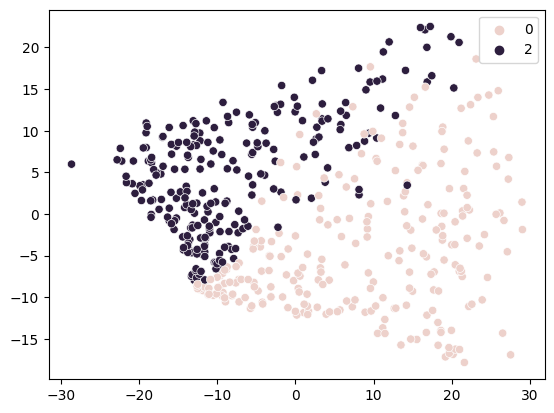

In [4]:
plot_features("Acrobot-v1", ents, clips)

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)

Softmax accuracy


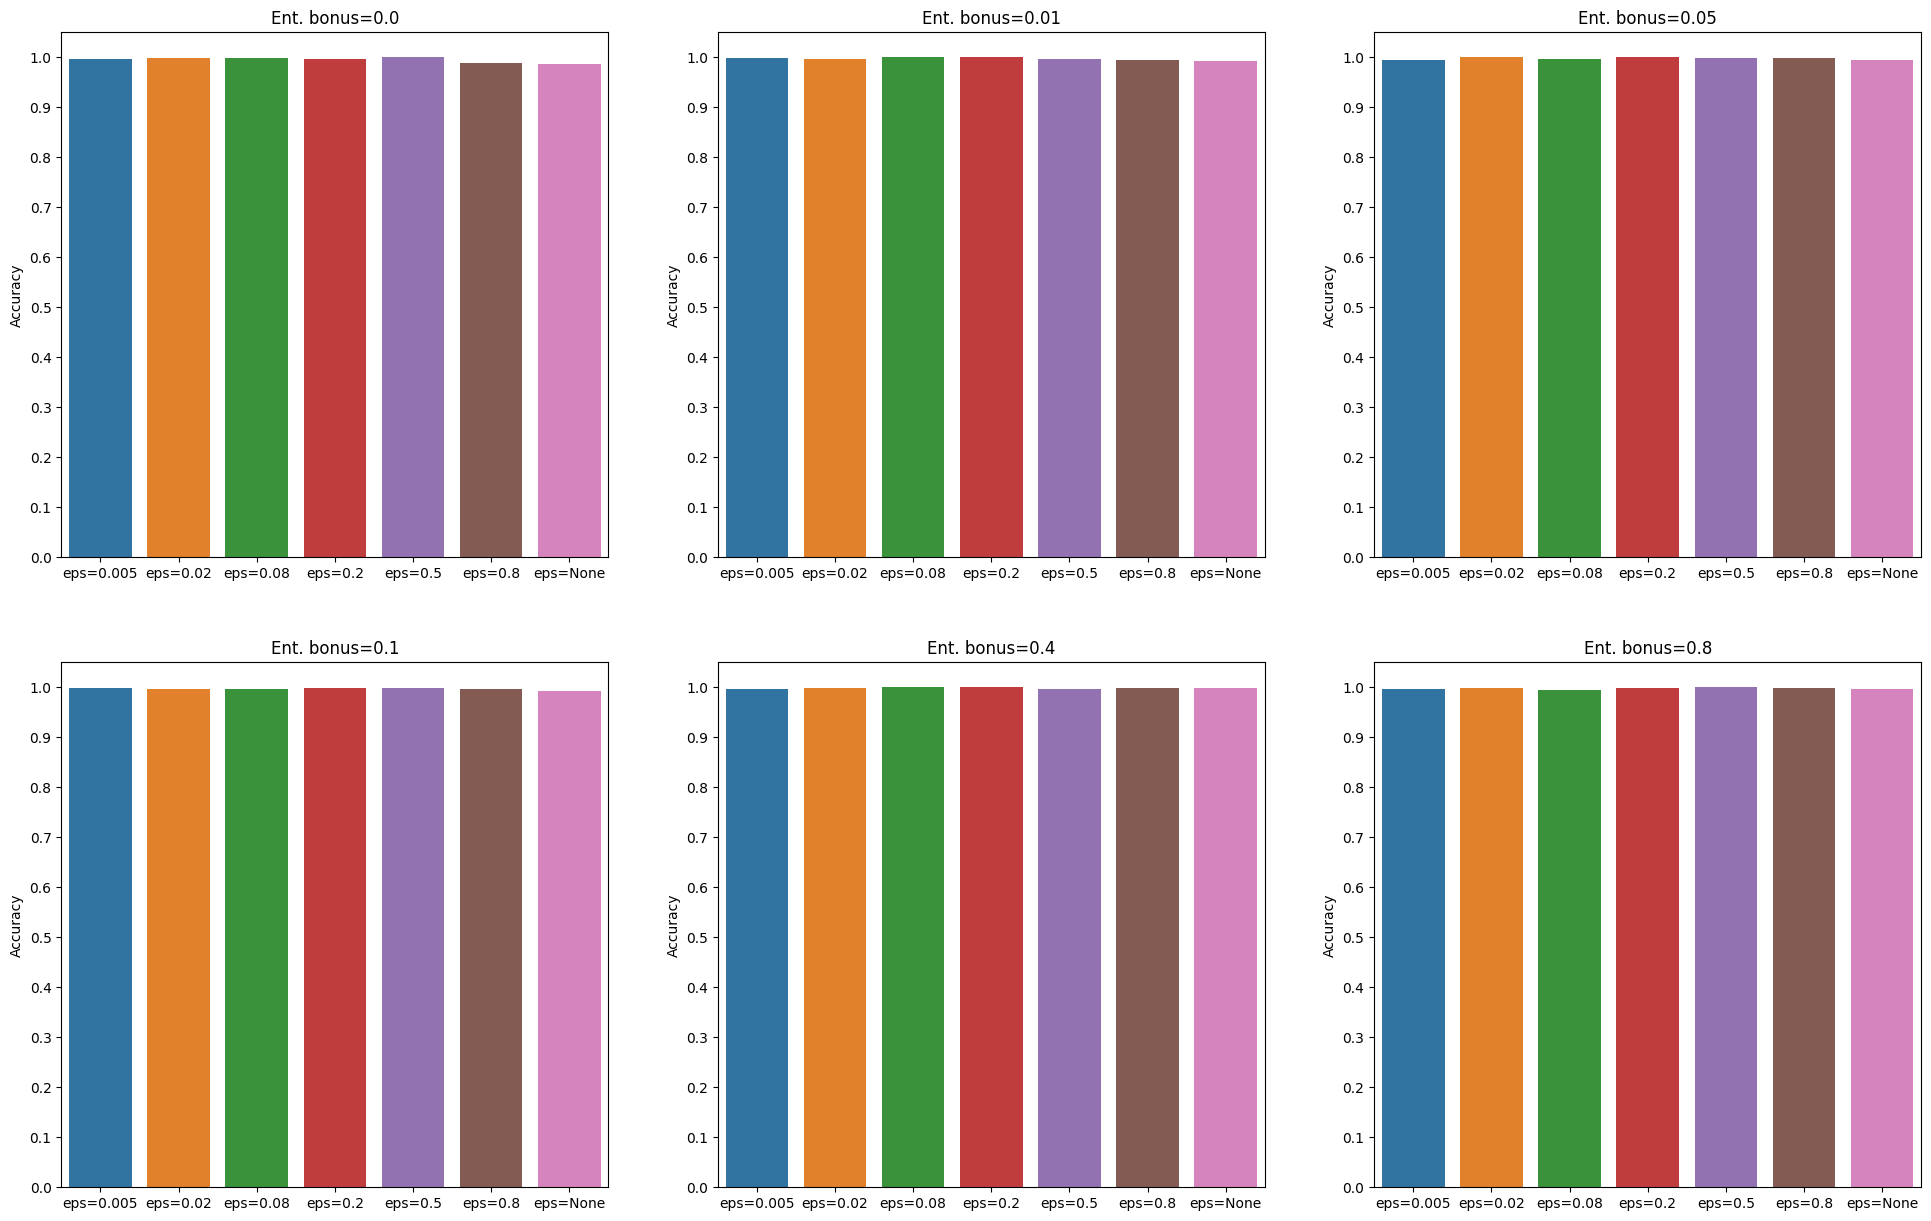

In [5]:
classify("Acrobot-v1", ents, clips, seed=0)

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)

Softmax accuracy


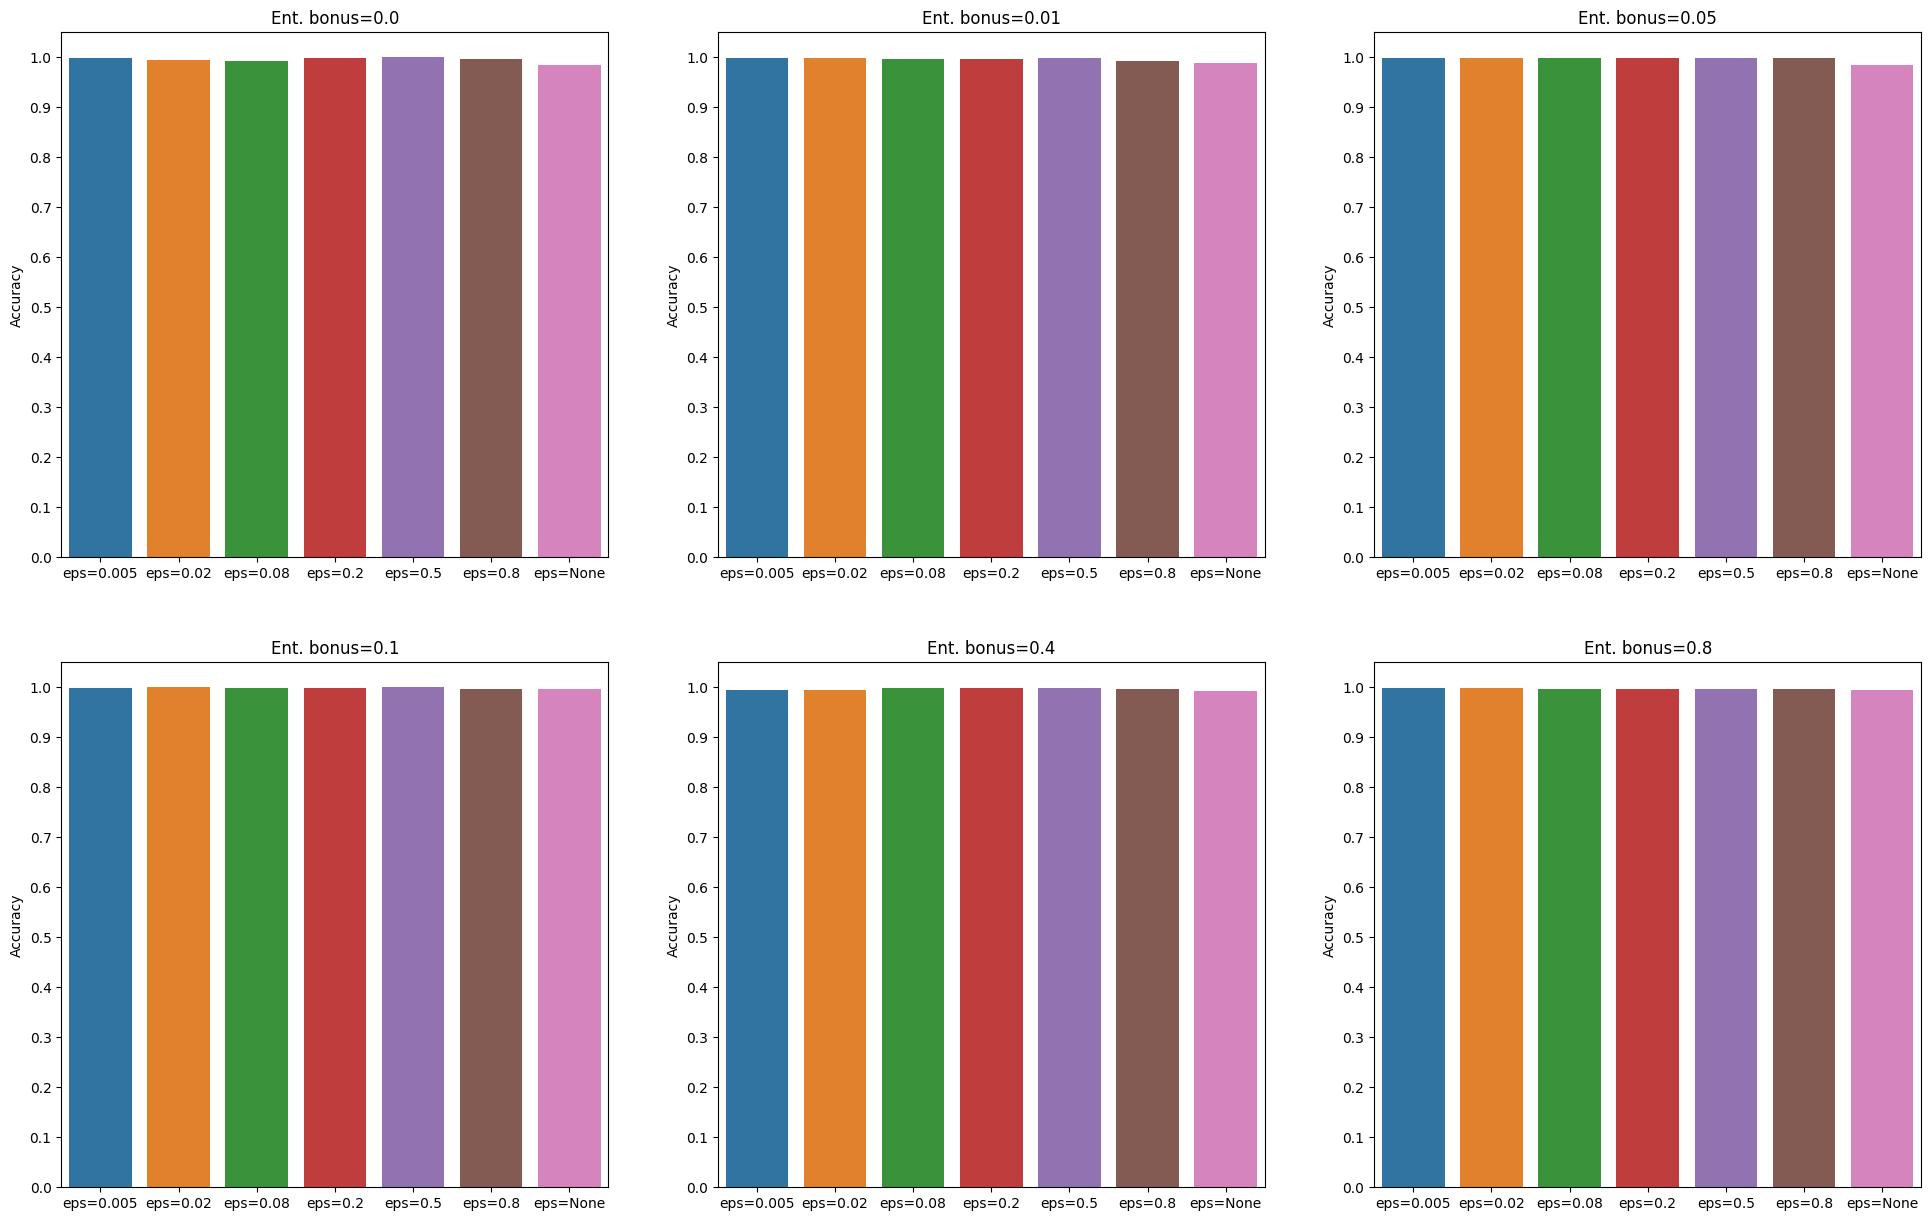

In [6]:
classify("Acrobot-v1", ents, clips, seed=3)

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)
sF shape: (8, 6, 7, 64)
Max sF: 1183.4887888759772

Singular values of feature matrix


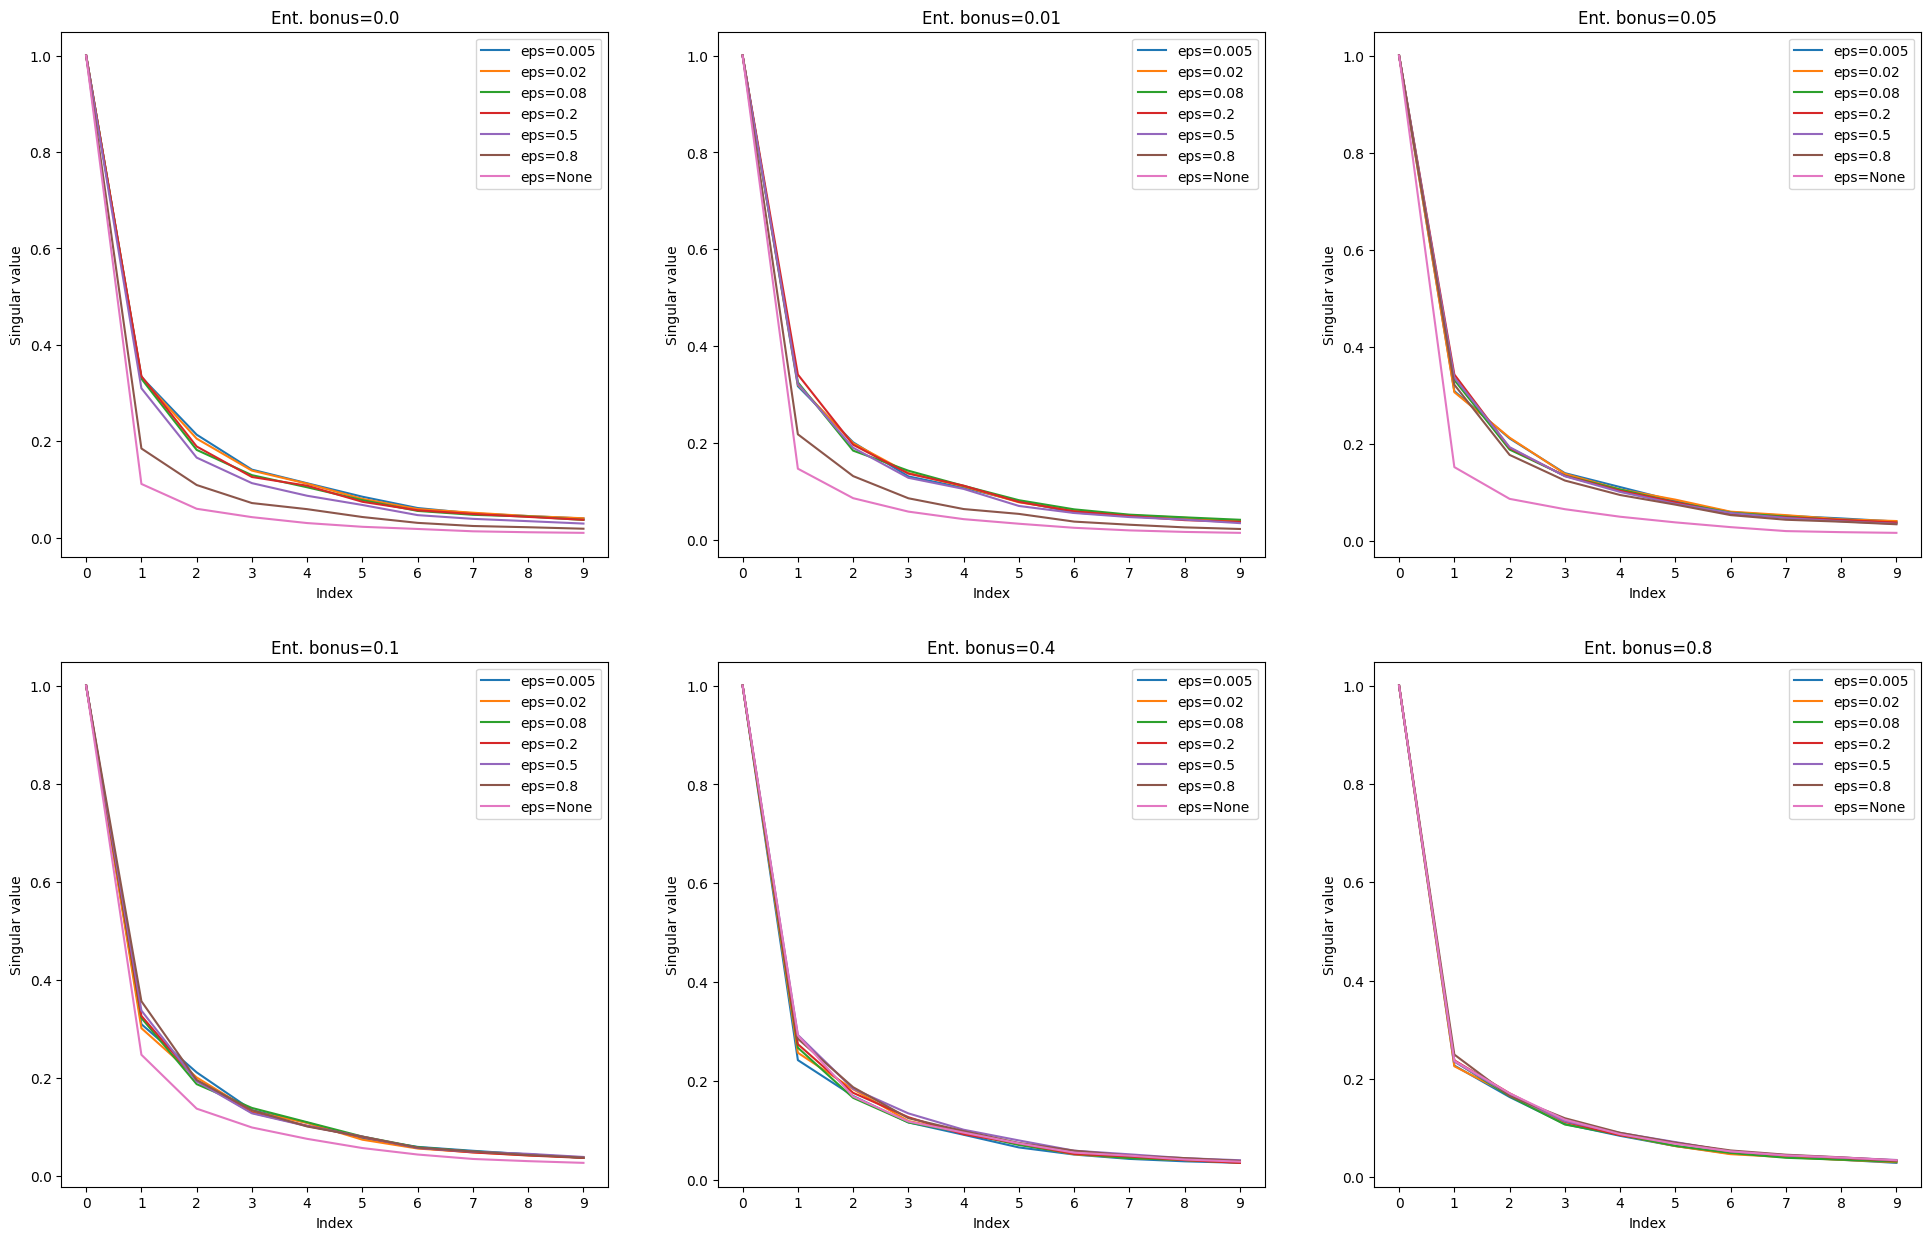

In [7]:
plot_svd("Acrobot-v1", ents, clips)

Features shape: (8, 6, 7, 500, 64)
Max feature: 30.808845386314914

Abs values of feature matrix


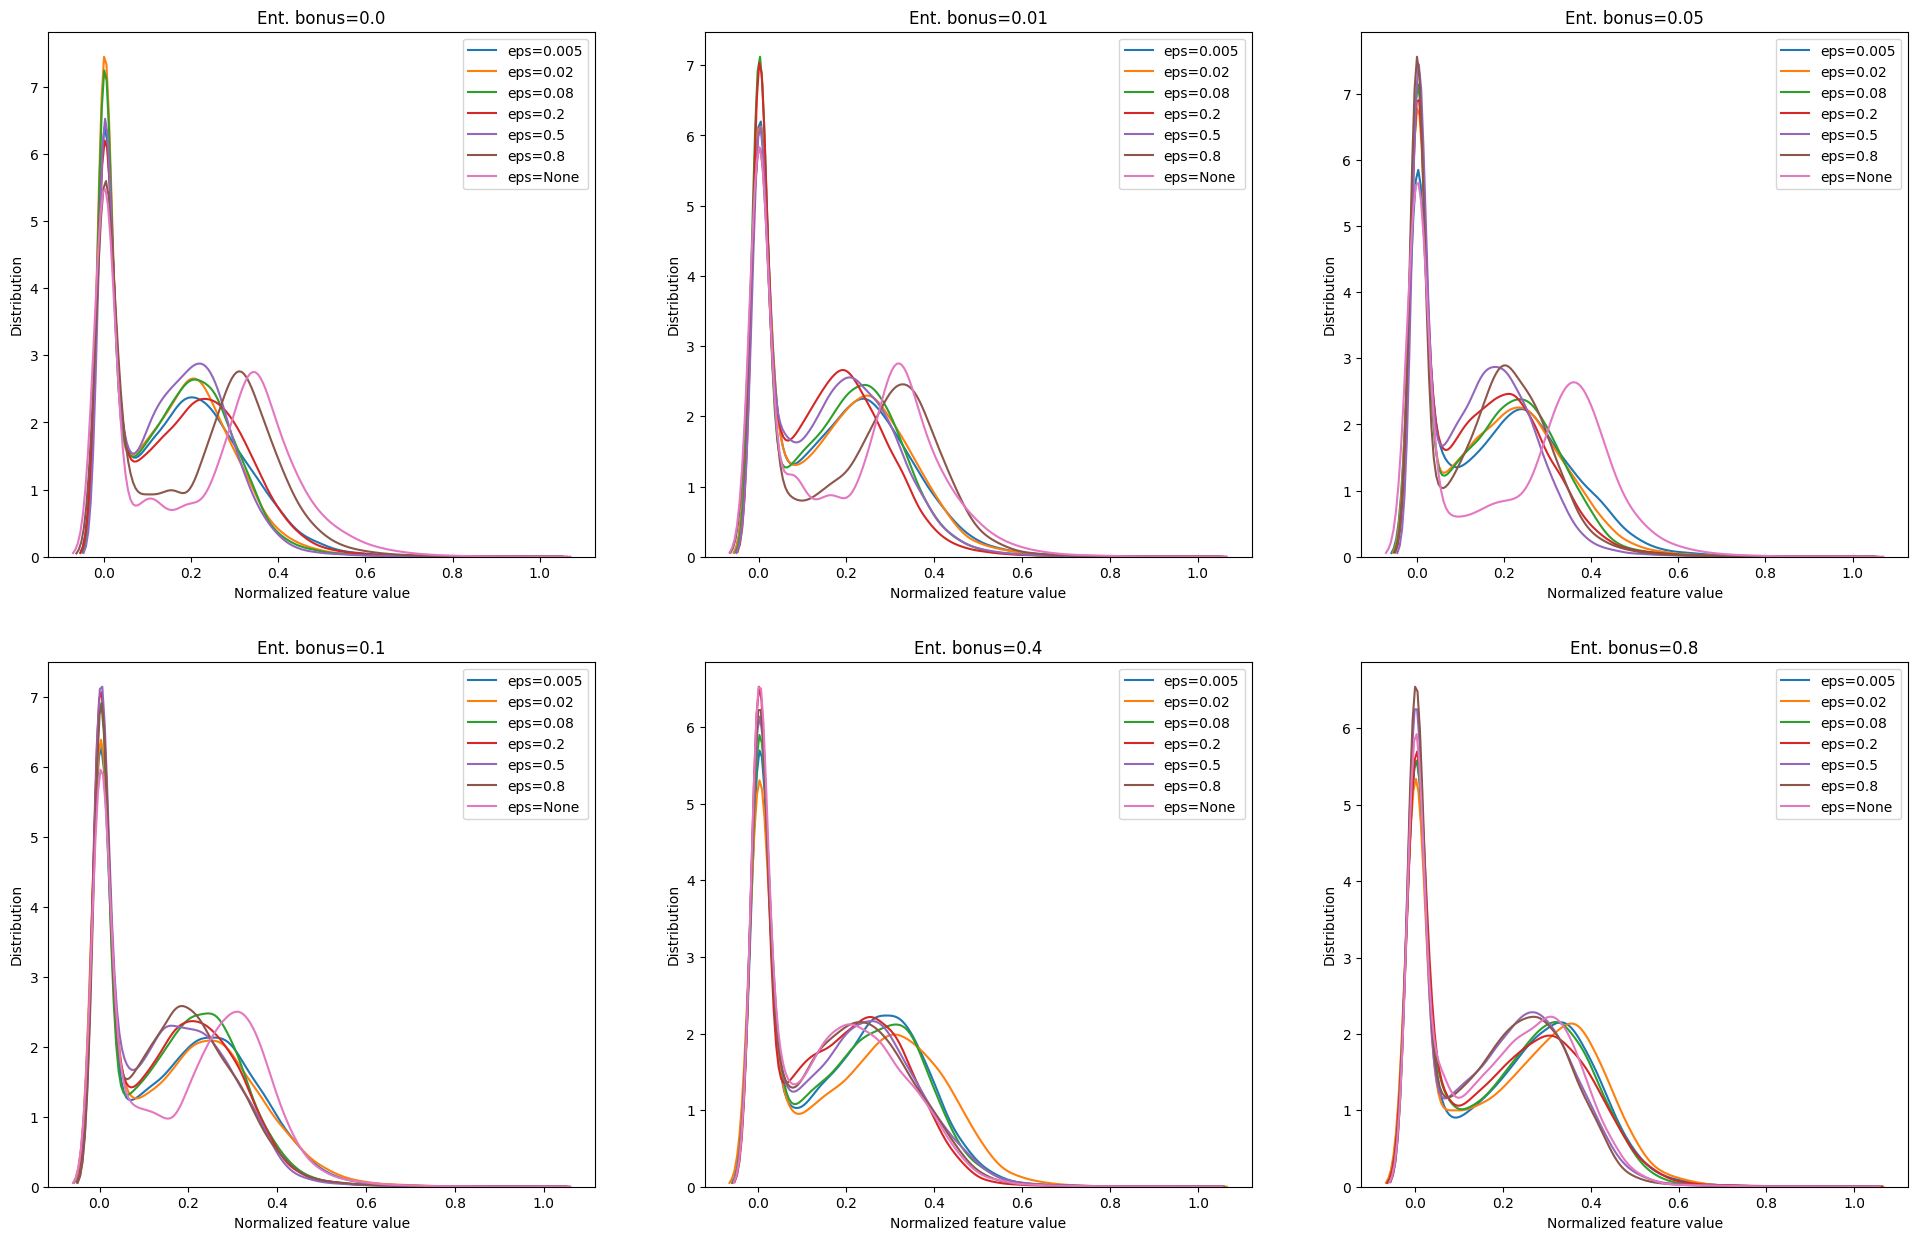

In [8]:
plot_sparsity("Acrobot-v1", ents, clips)

## 2. Asterix

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
(1000, 2)


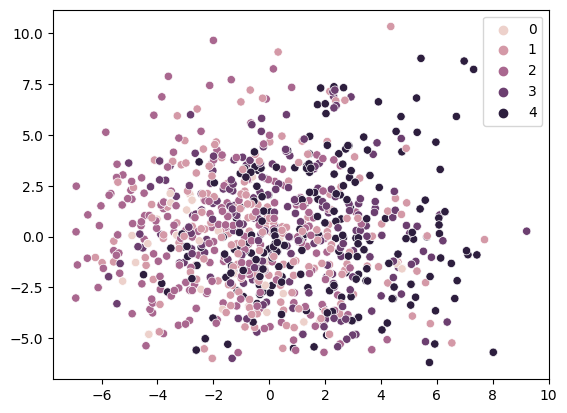

In [9]:
plot_features("Asterix-MinAtar", ents, clips)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)

Softmax accuracy


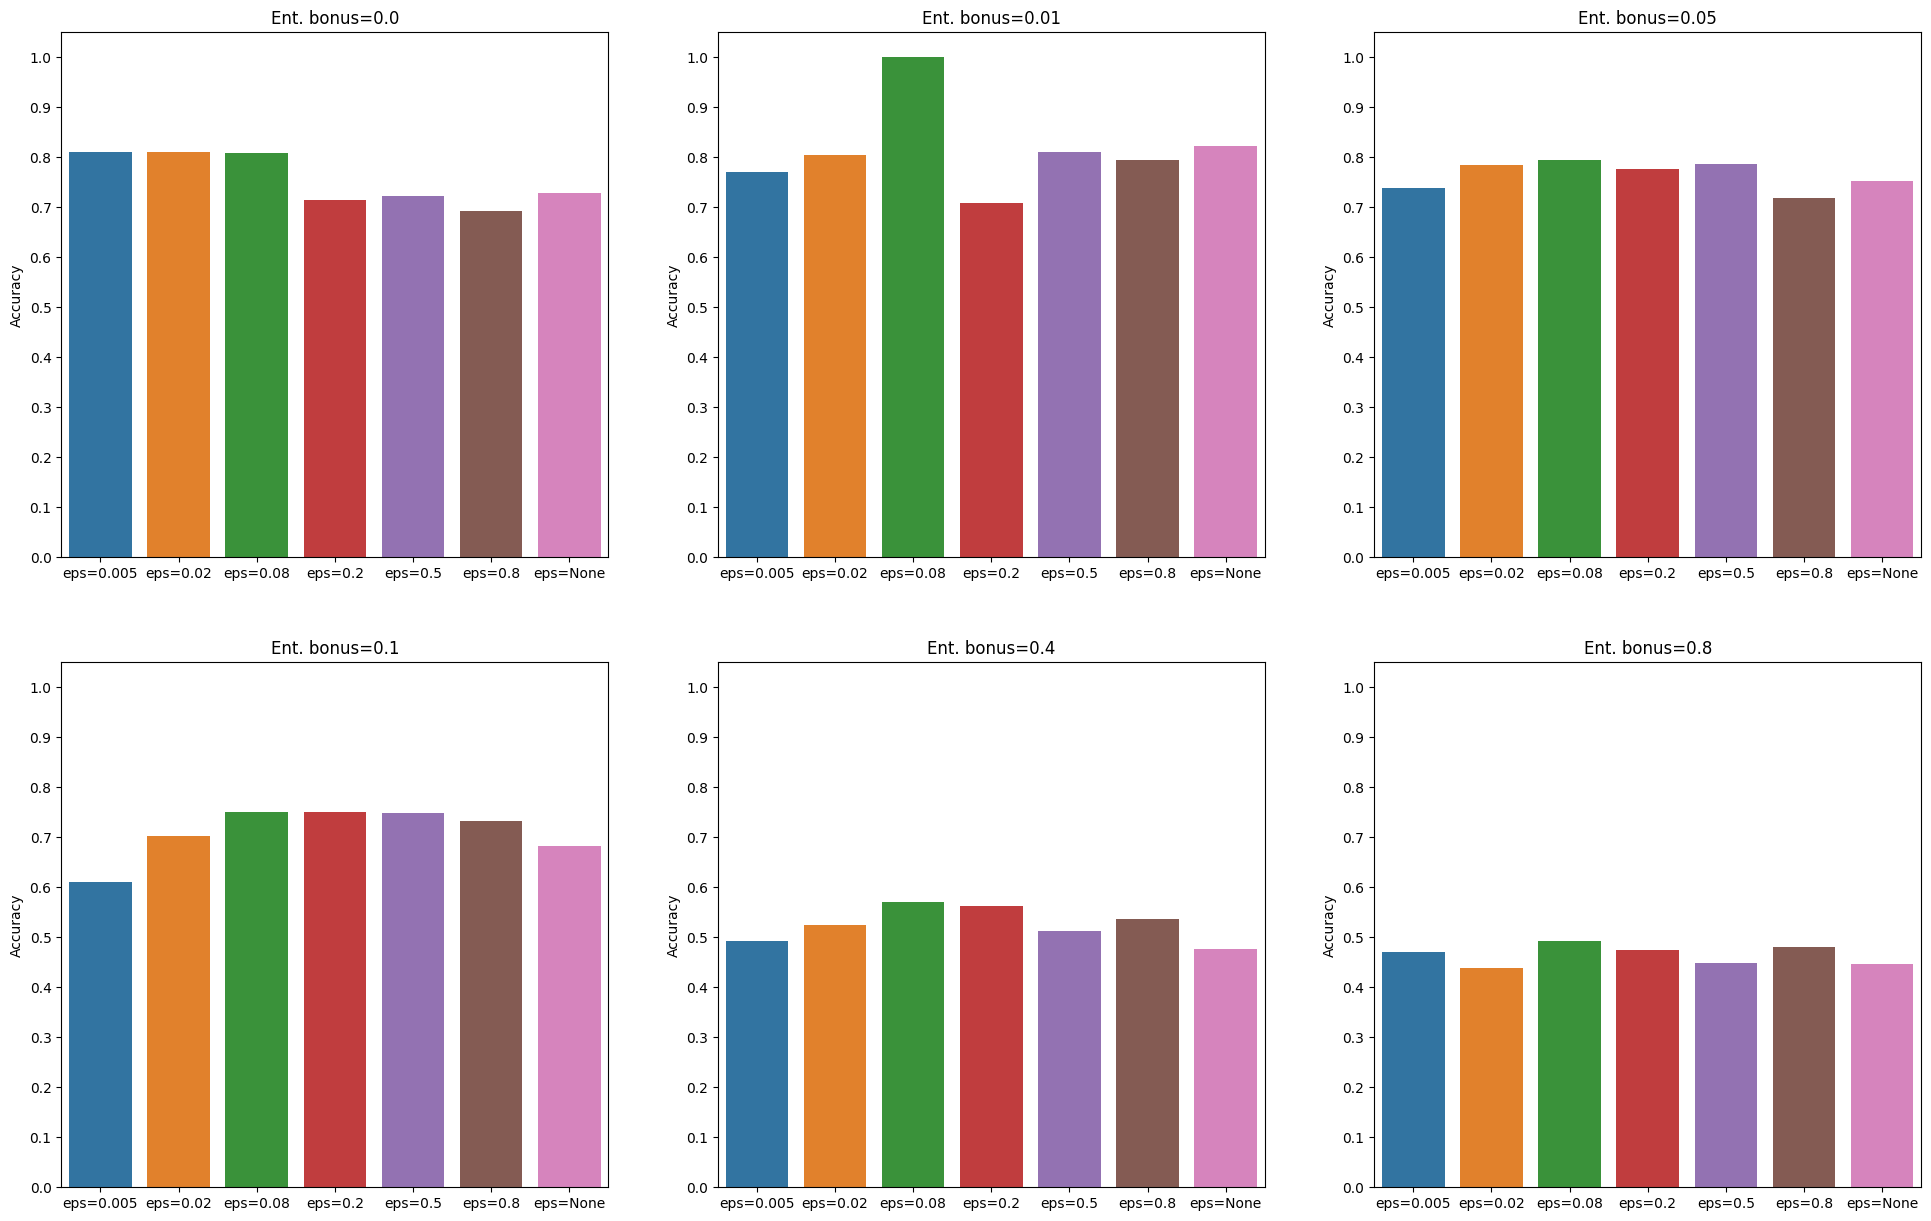

In [10]:
classify("Asterix-MinAtar", ents, clips, seed=0)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)

Softmax accuracy


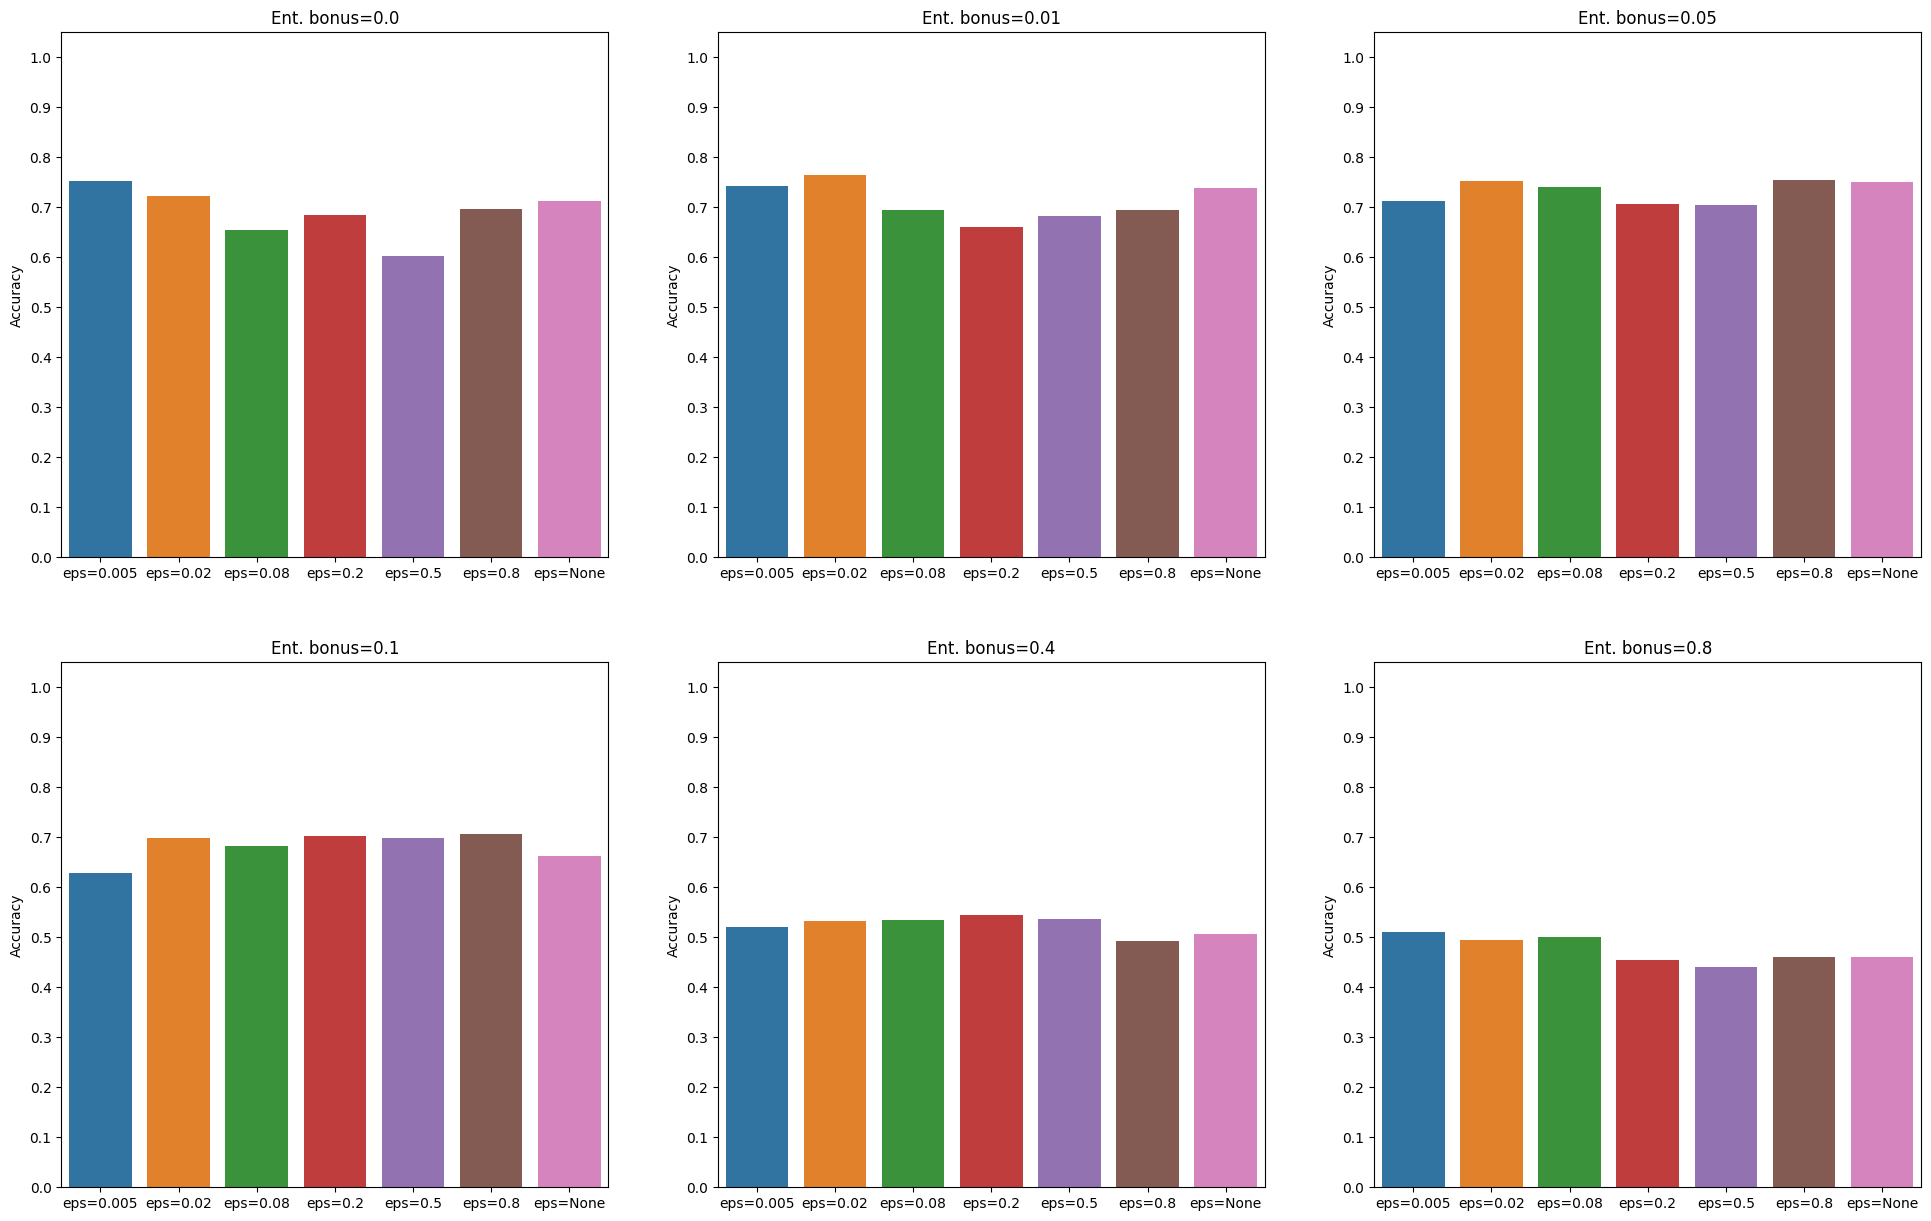

In [11]:
classify("Asterix-MinAtar", ents, clips, seed=3)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
sF shape: (8, 6, 7, 256)
Max sF: 1183.4037

Singular values of feature matrix


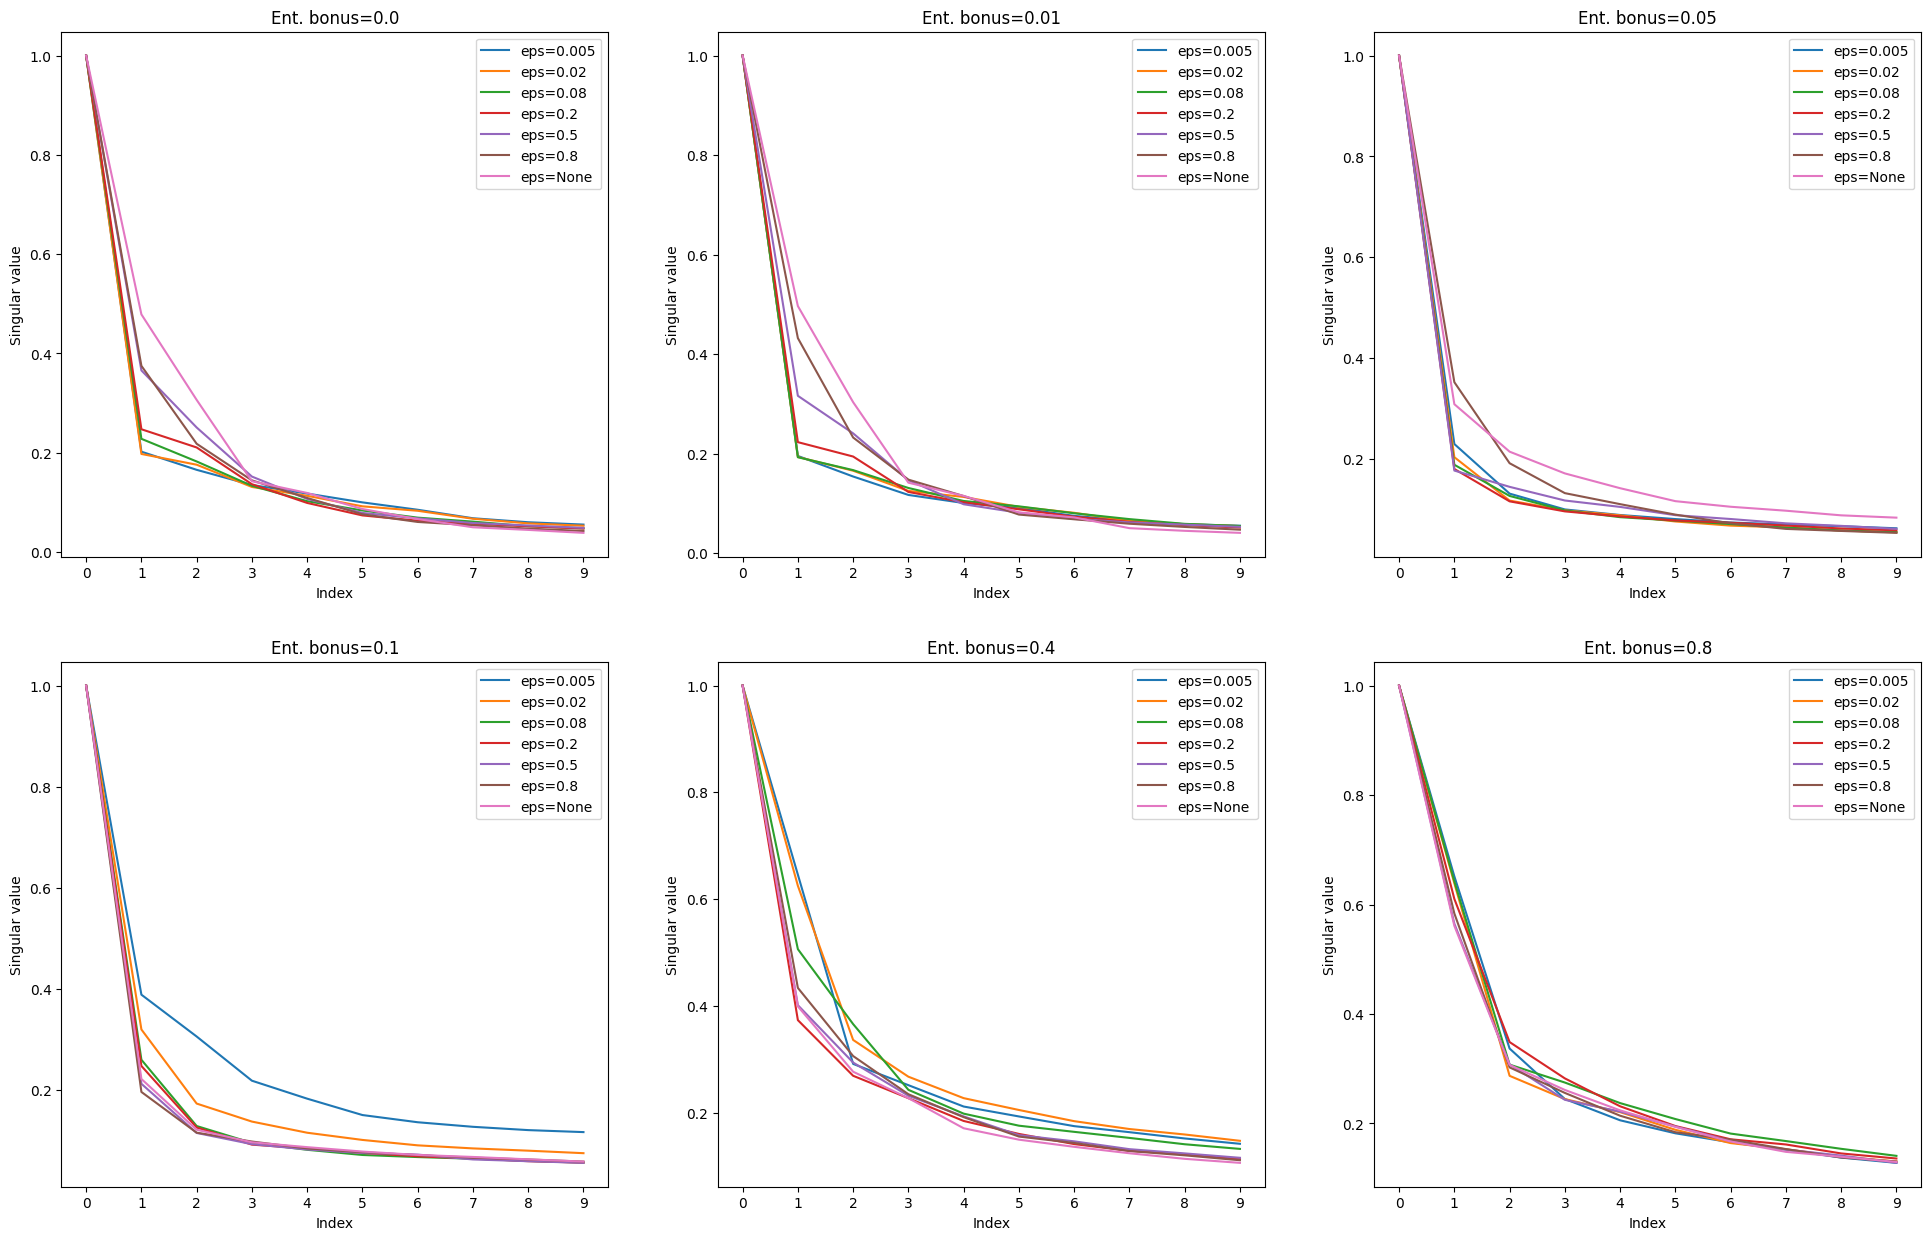

In [12]:
plot_svd("Asterix-MinAtar", ents, clips)

Features shape: (8, 6, 7, 1000, 256)
Max feature: 19.859348

Abs values of feature matrix


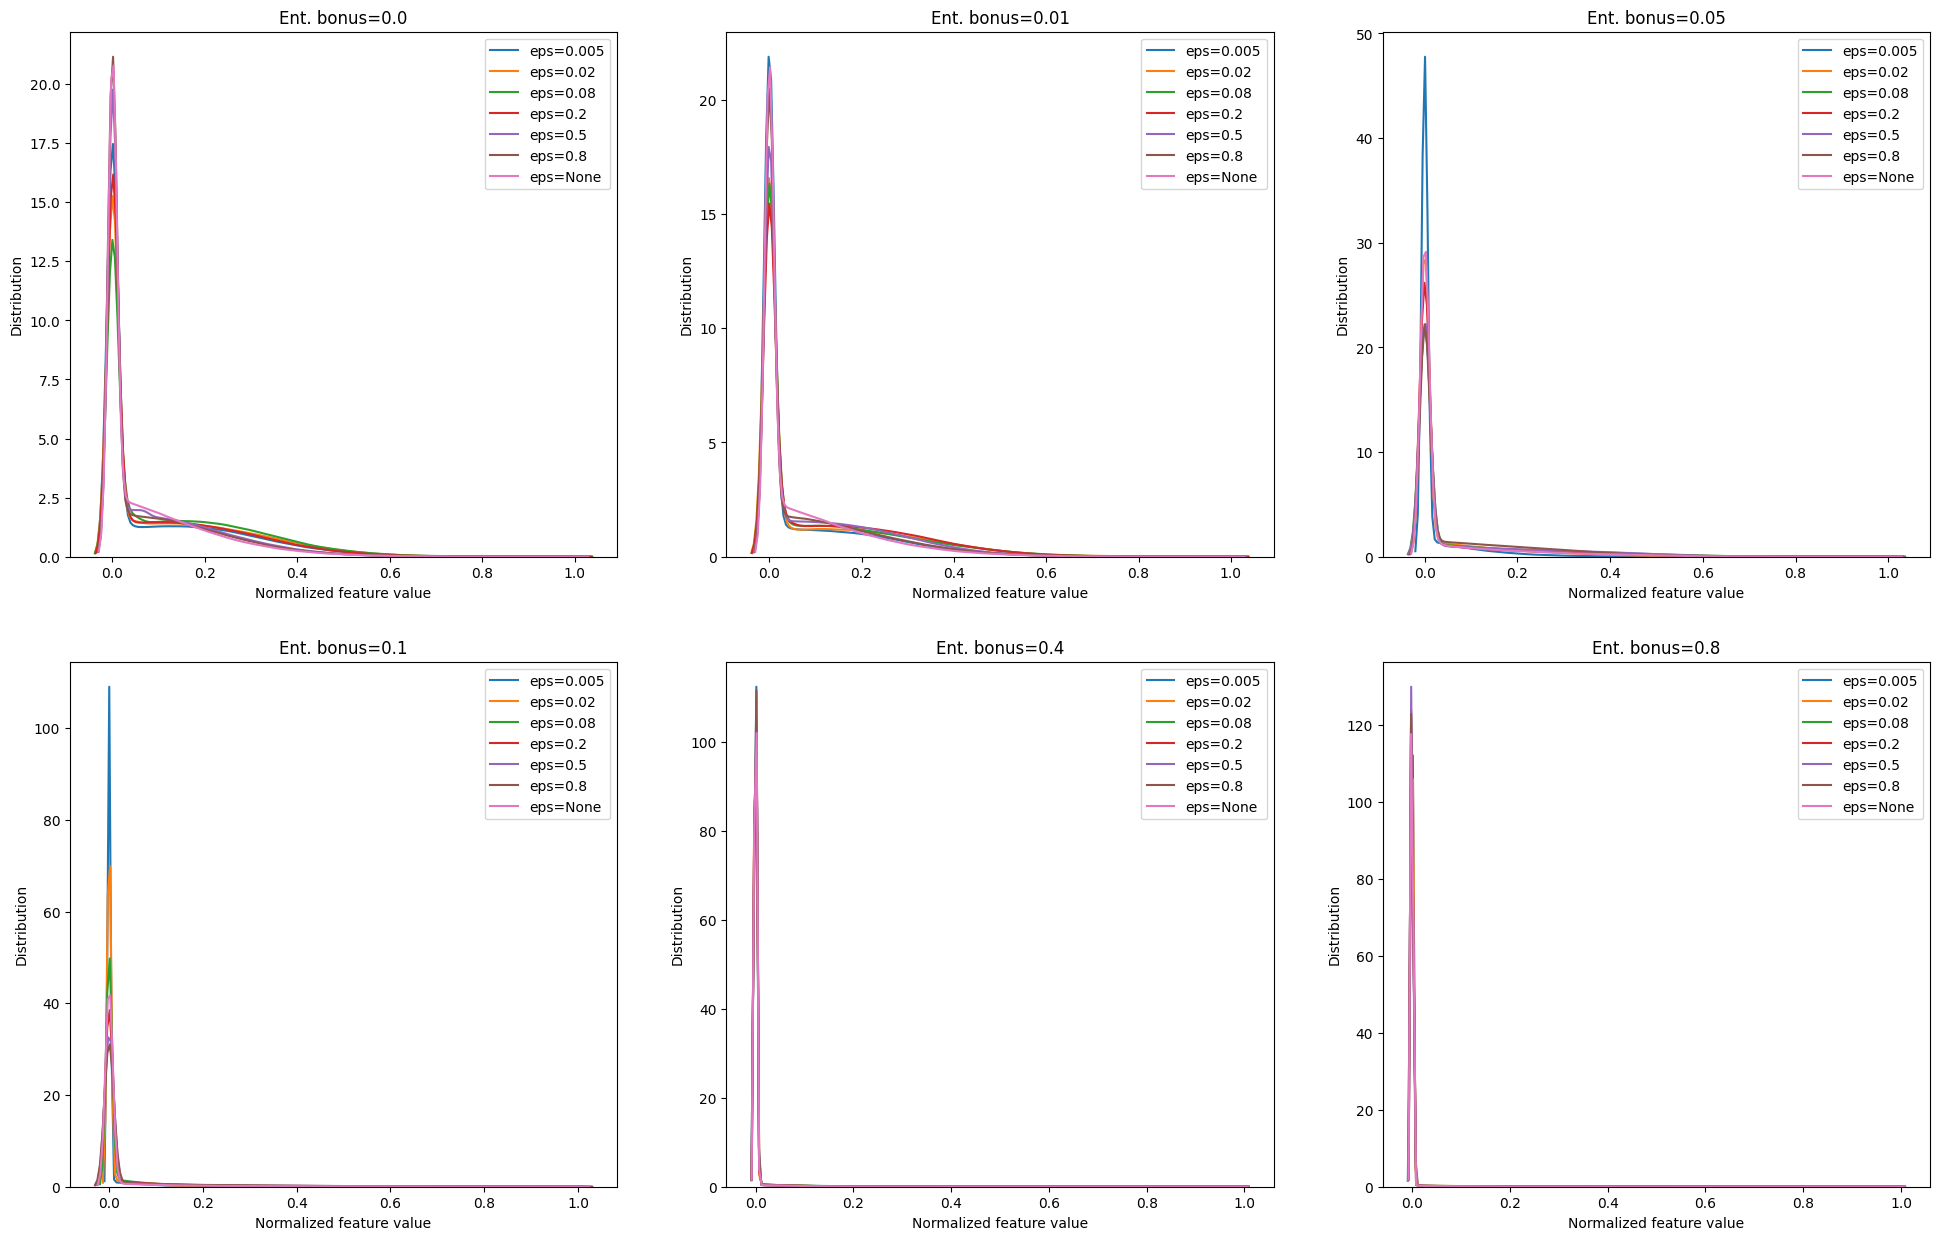

In [13]:
plot_sparsity("Asterix-MinAtar", ents, clips)

## 3. Breakout

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
(1000, 2)


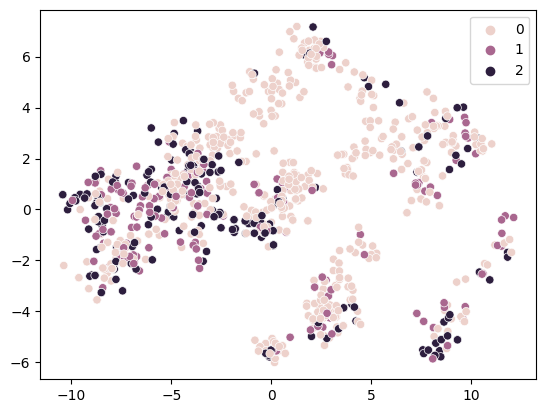

In [14]:
plot_features("Breakout-MinAtar", ents, clips)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)

Softmax accuracy


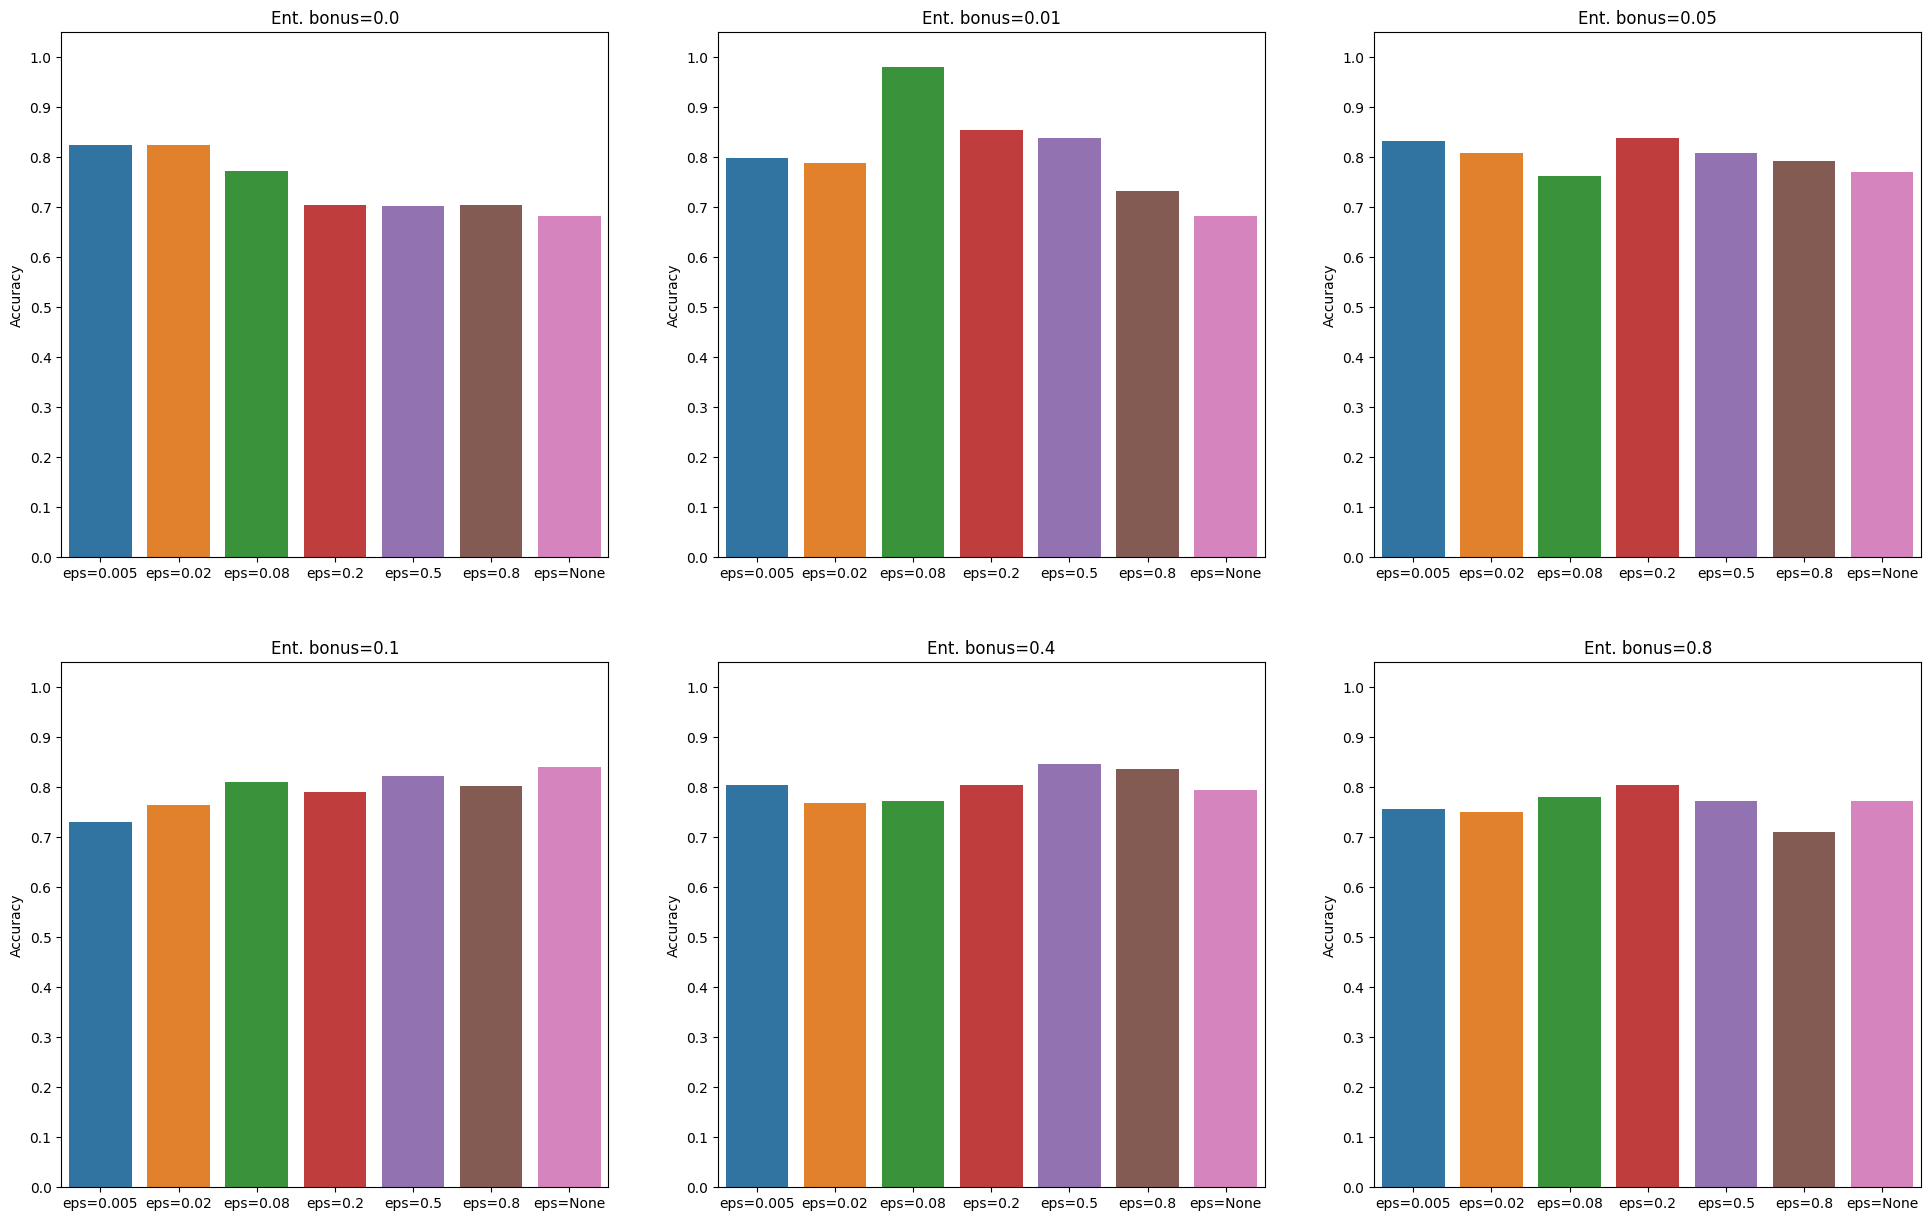

In [15]:
classify("Breakout-MinAtar", ents, clips, seed=0)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)

Softmax accuracy


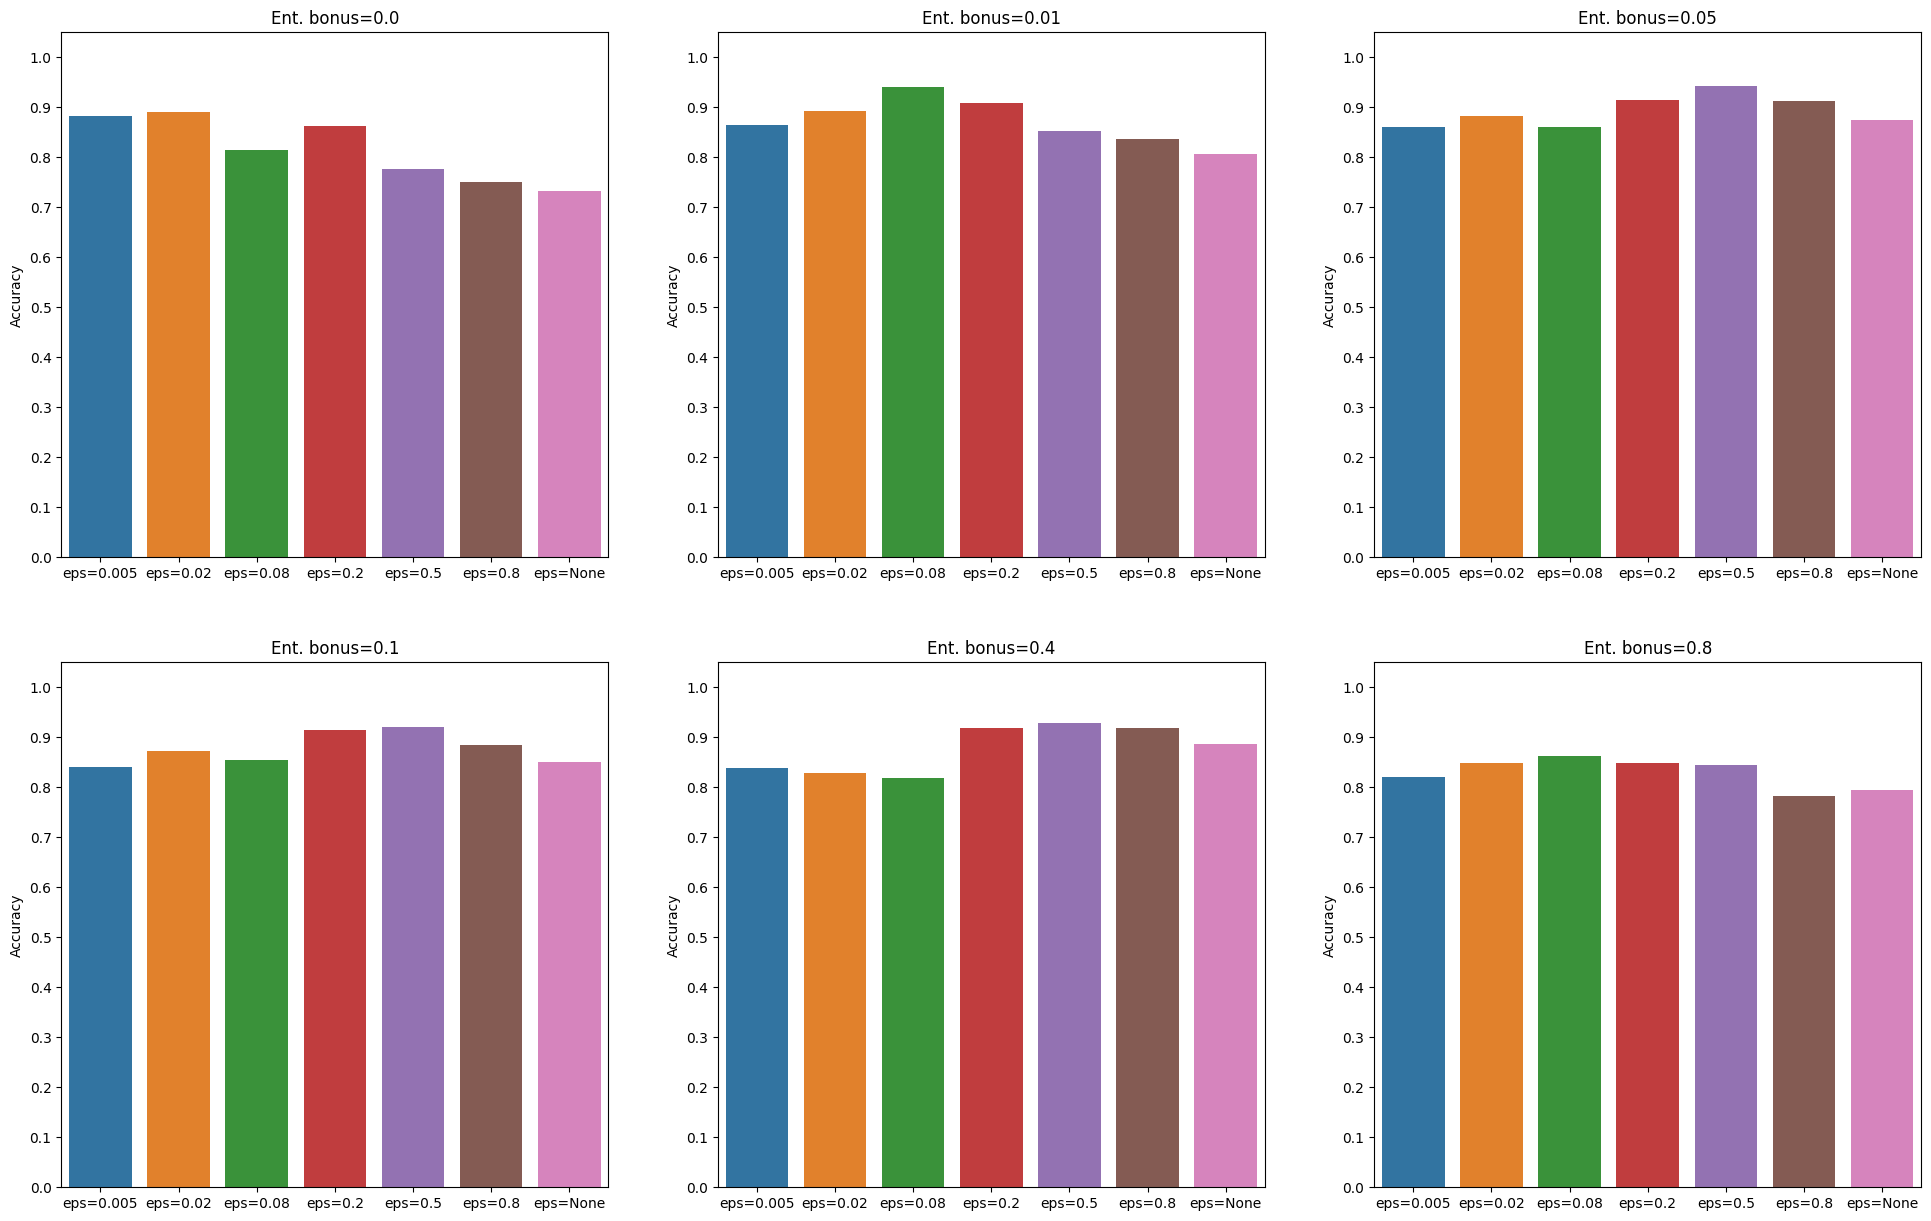

In [16]:
classify("Breakout-MinAtar", ents, clips, seed=3)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
sF shape: (8, 6, 7, 256)
Max sF: 756.2898

Singular values of feature matrix


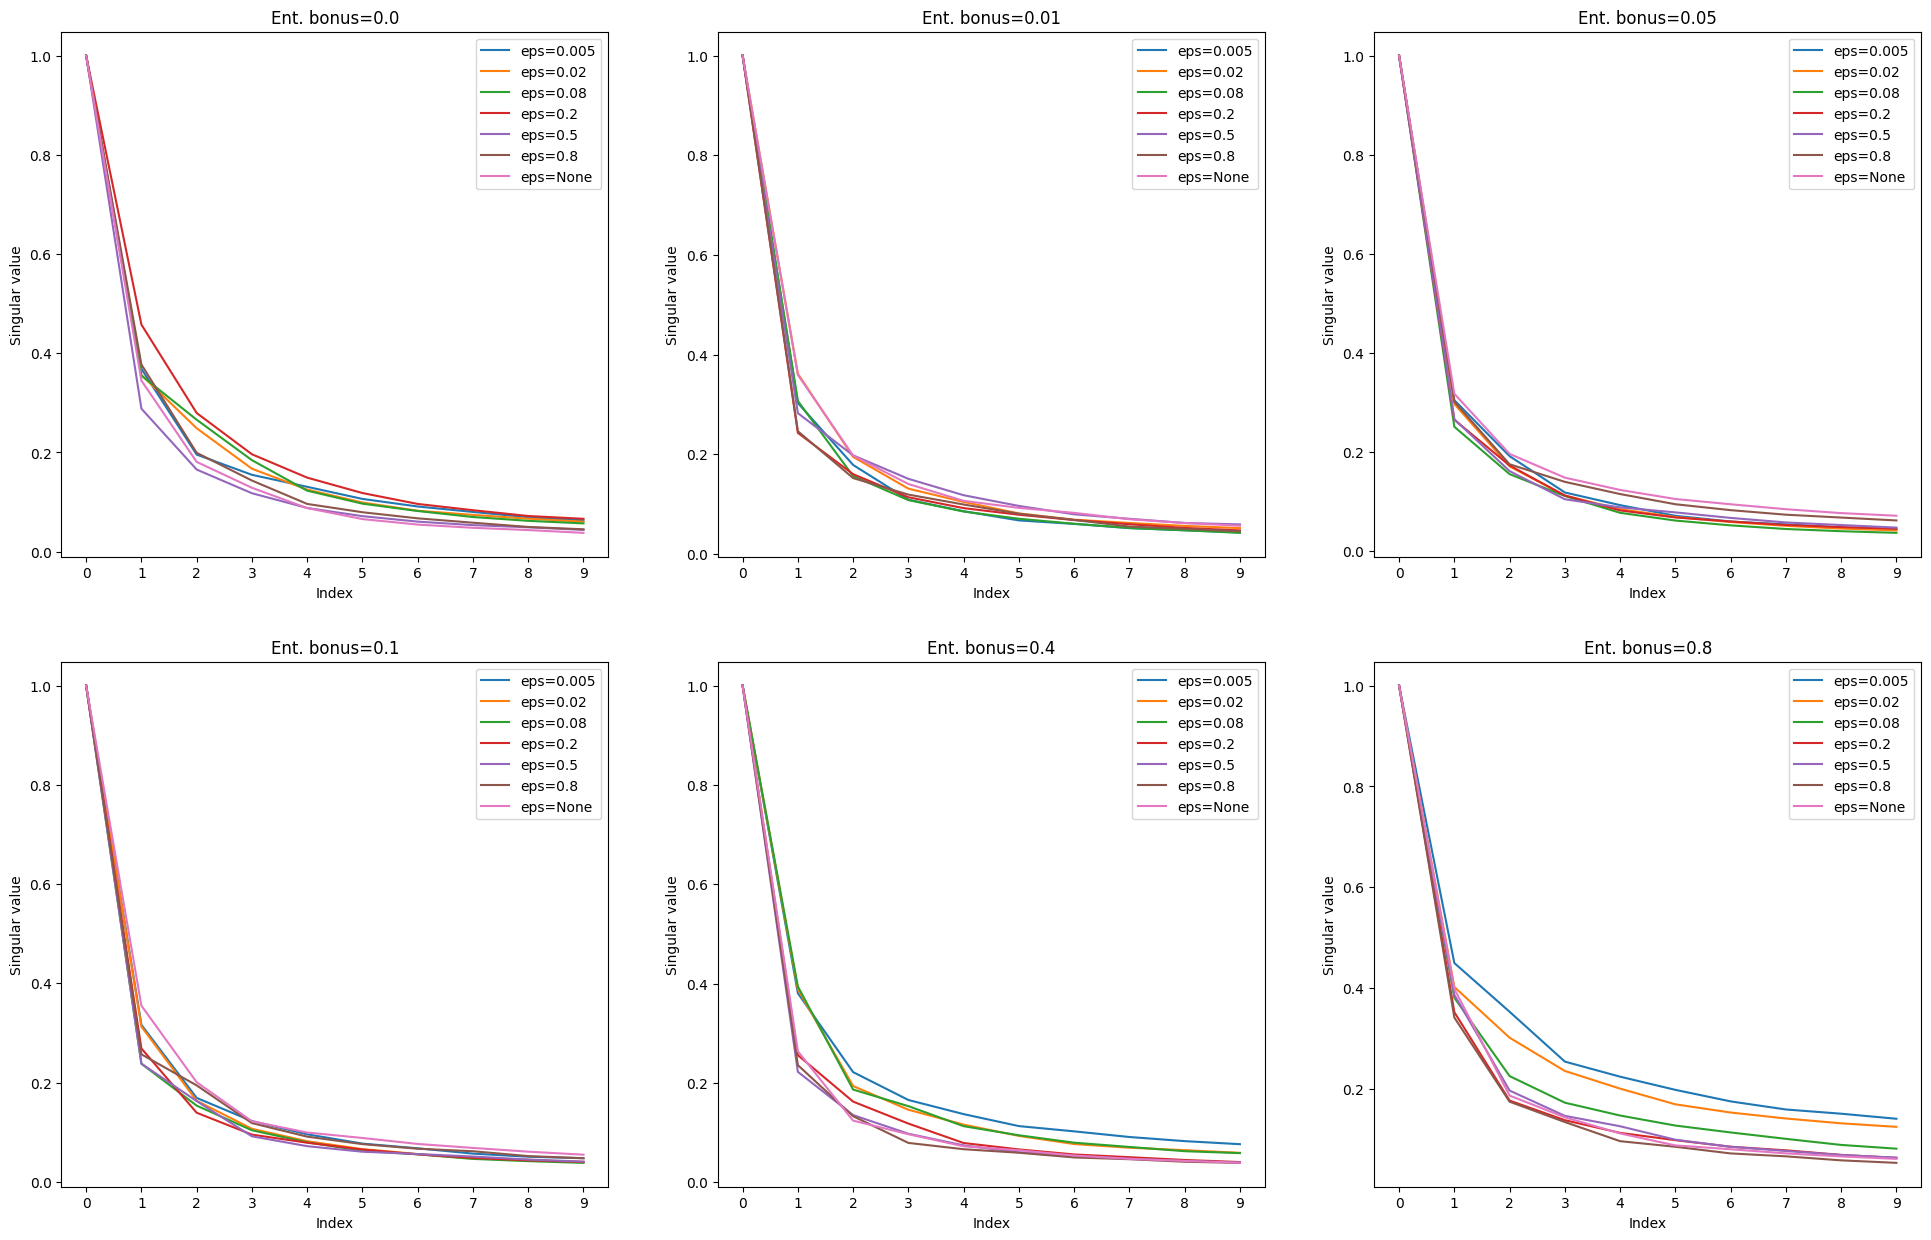

In [17]:
plot_svd("Breakout-MinAtar", ents, clips)

Features shape: (8, 6, 7, 1000, 256)
Max feature: 12.35207

Abs values of feature matrix


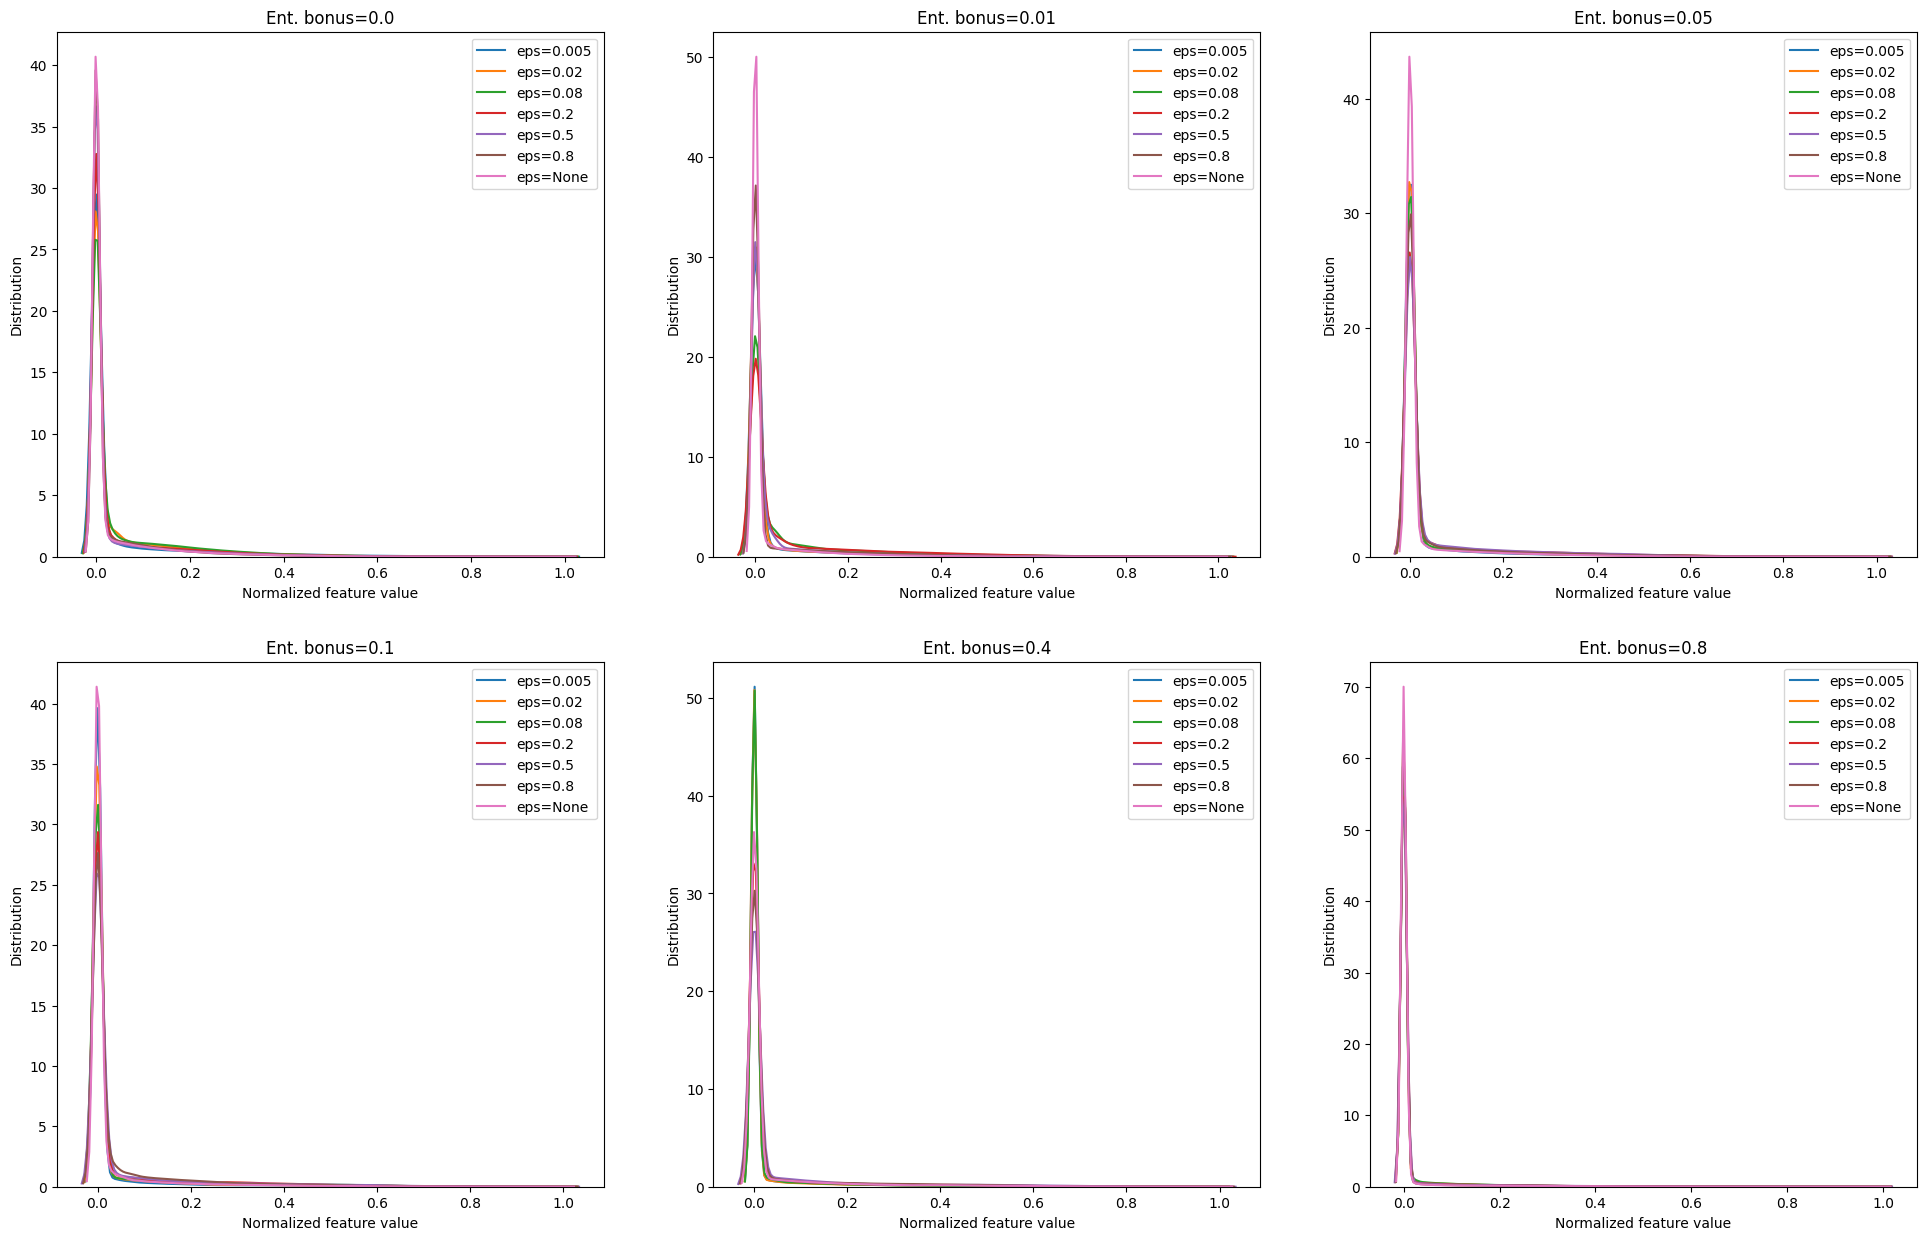

In [18]:
plot_sparsity("Breakout-MinAtar", ents, clips)

## 4. CartPole

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)
(500, 2)


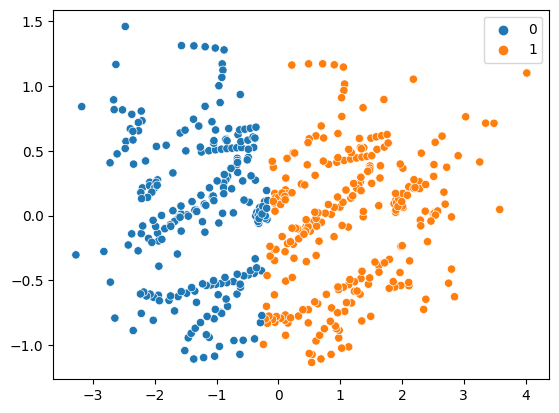

In [19]:
plot_features("CartPole-v1", ents, clips)

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)

Softmax accuracy


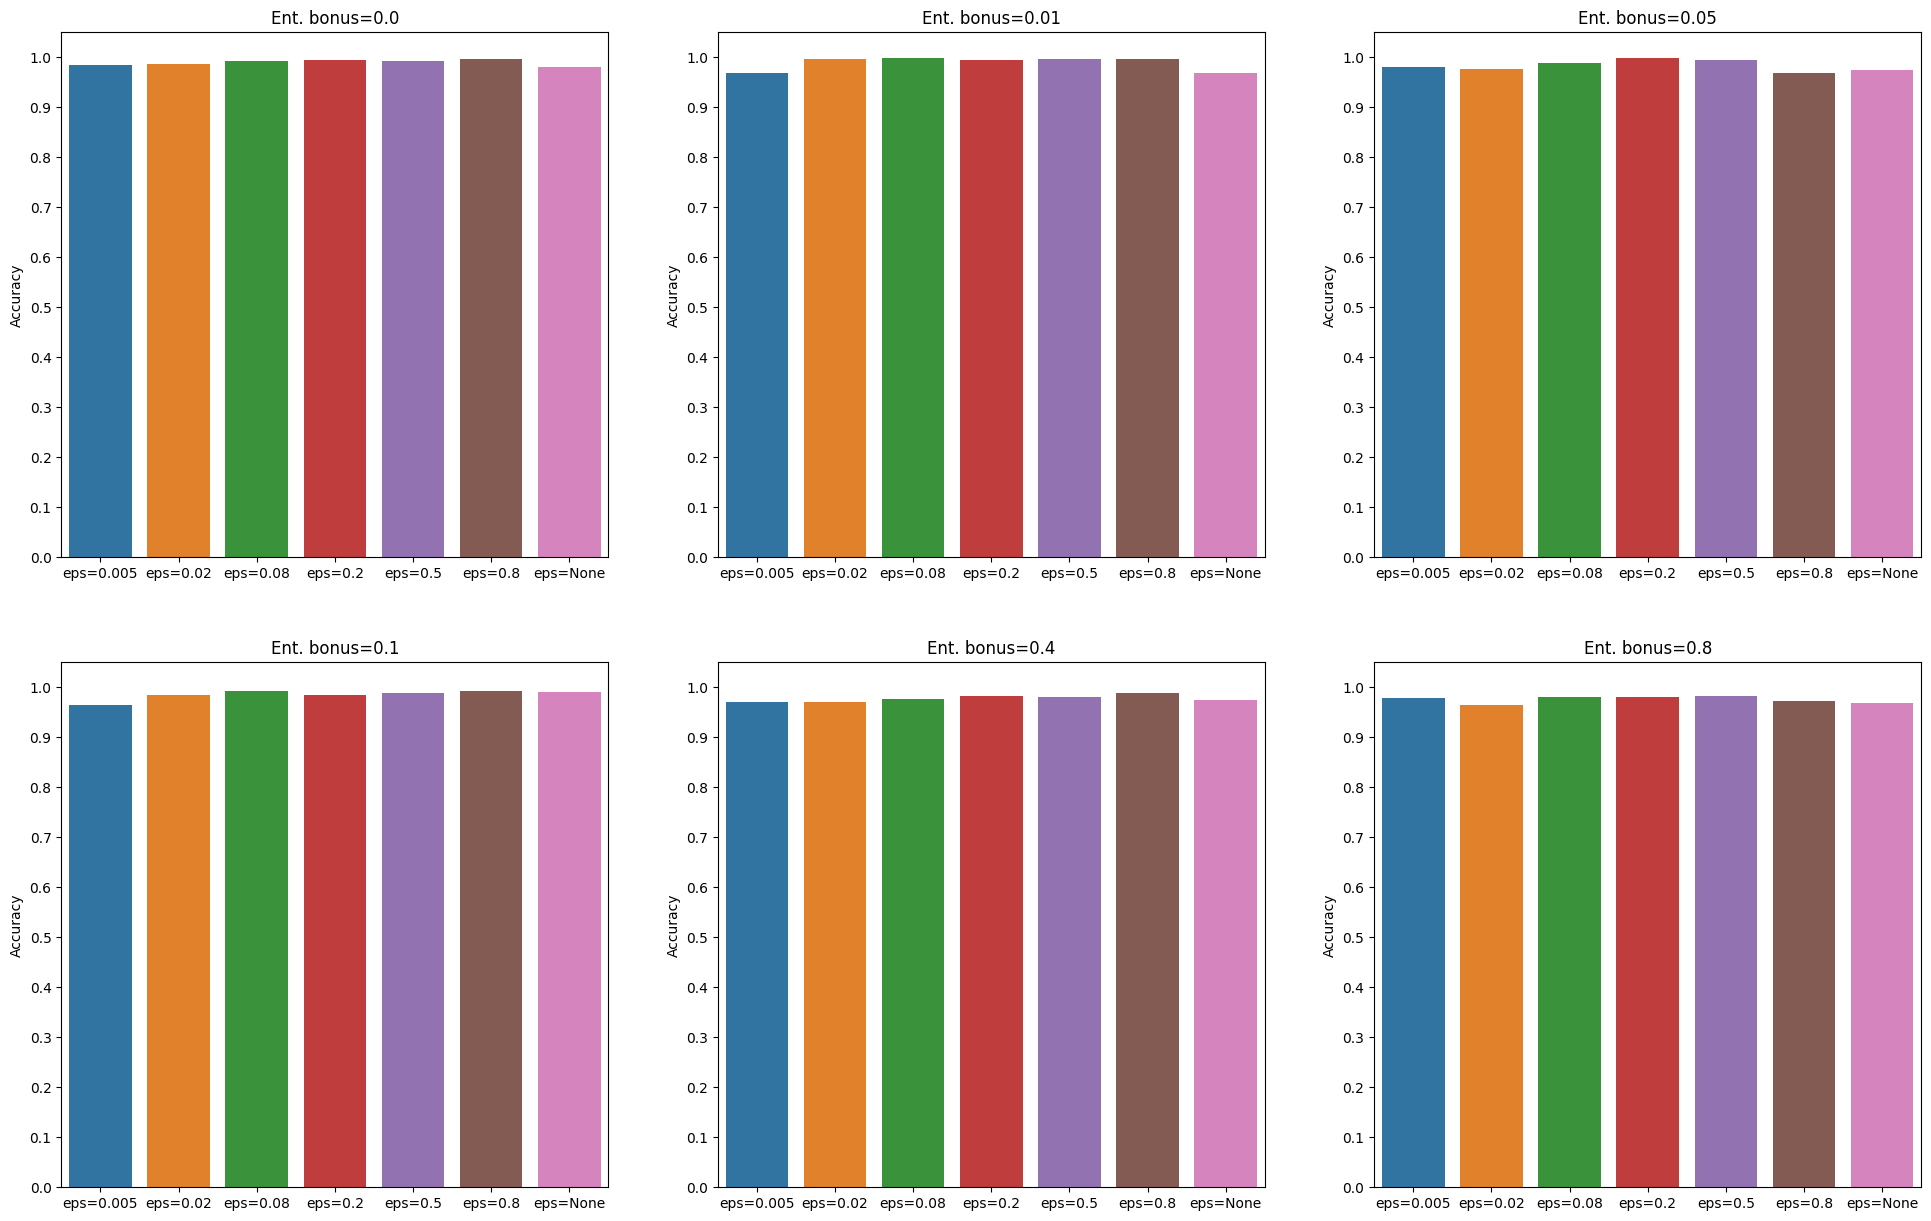

In [20]:
classify("CartPole-v1", ents, clips, seed=0)

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)

Softmax accuracy


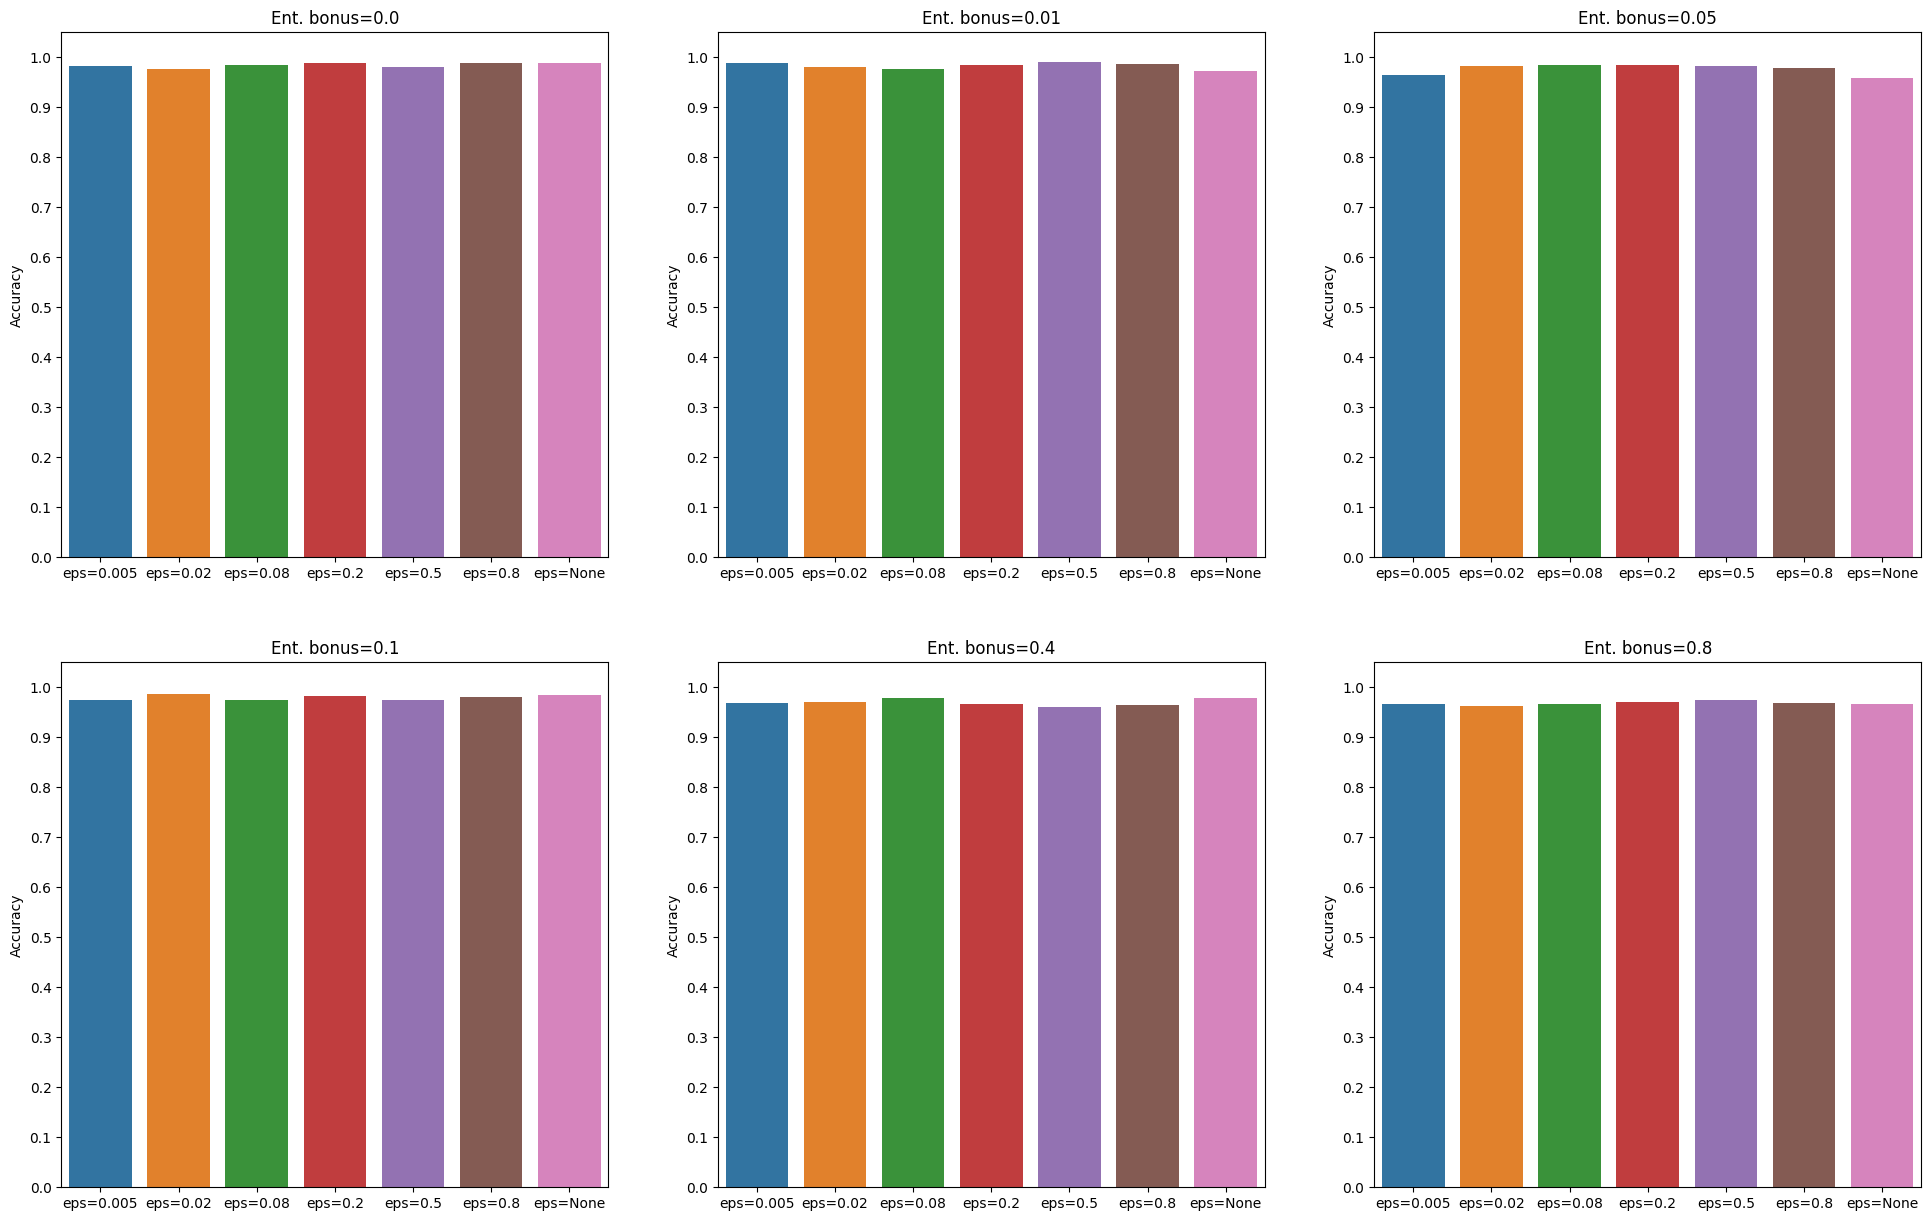

In [21]:
classify("CartPole-v1", ents, clips, seed=3)

Actions shape: (8, 6, 7, 500)
Features shape: (8, 6, 7, 500, 64)
sF shape: (8, 6, 7, 64)
Max sF: 907.1369127132289

Singular values of feature matrix


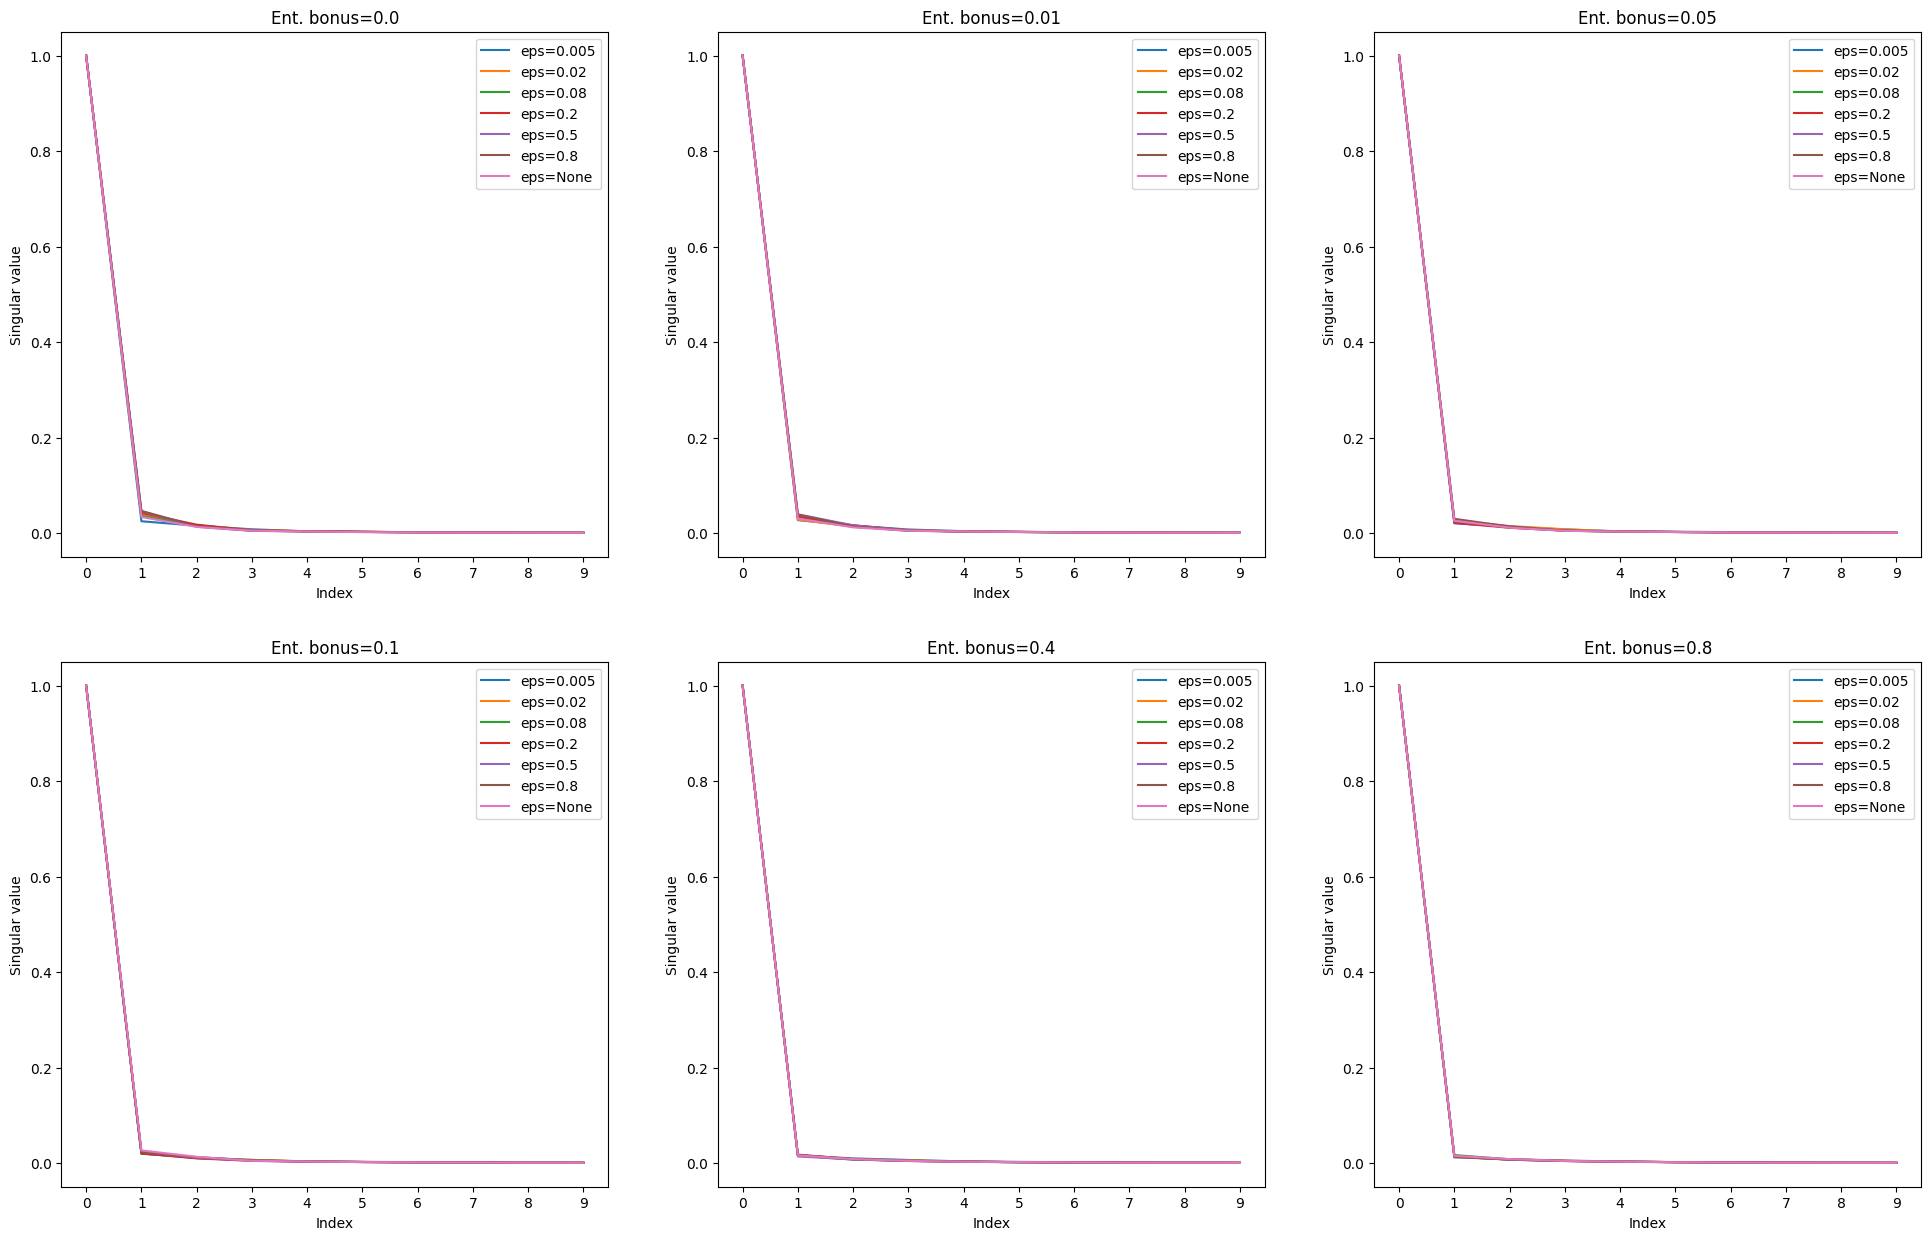

In [22]:
plot_svd("CartPole-v1", ents, clips)

Features shape: (8, 6, 7, 500, 64)
Max feature: 8.693768148402798

Abs values of feature matrix


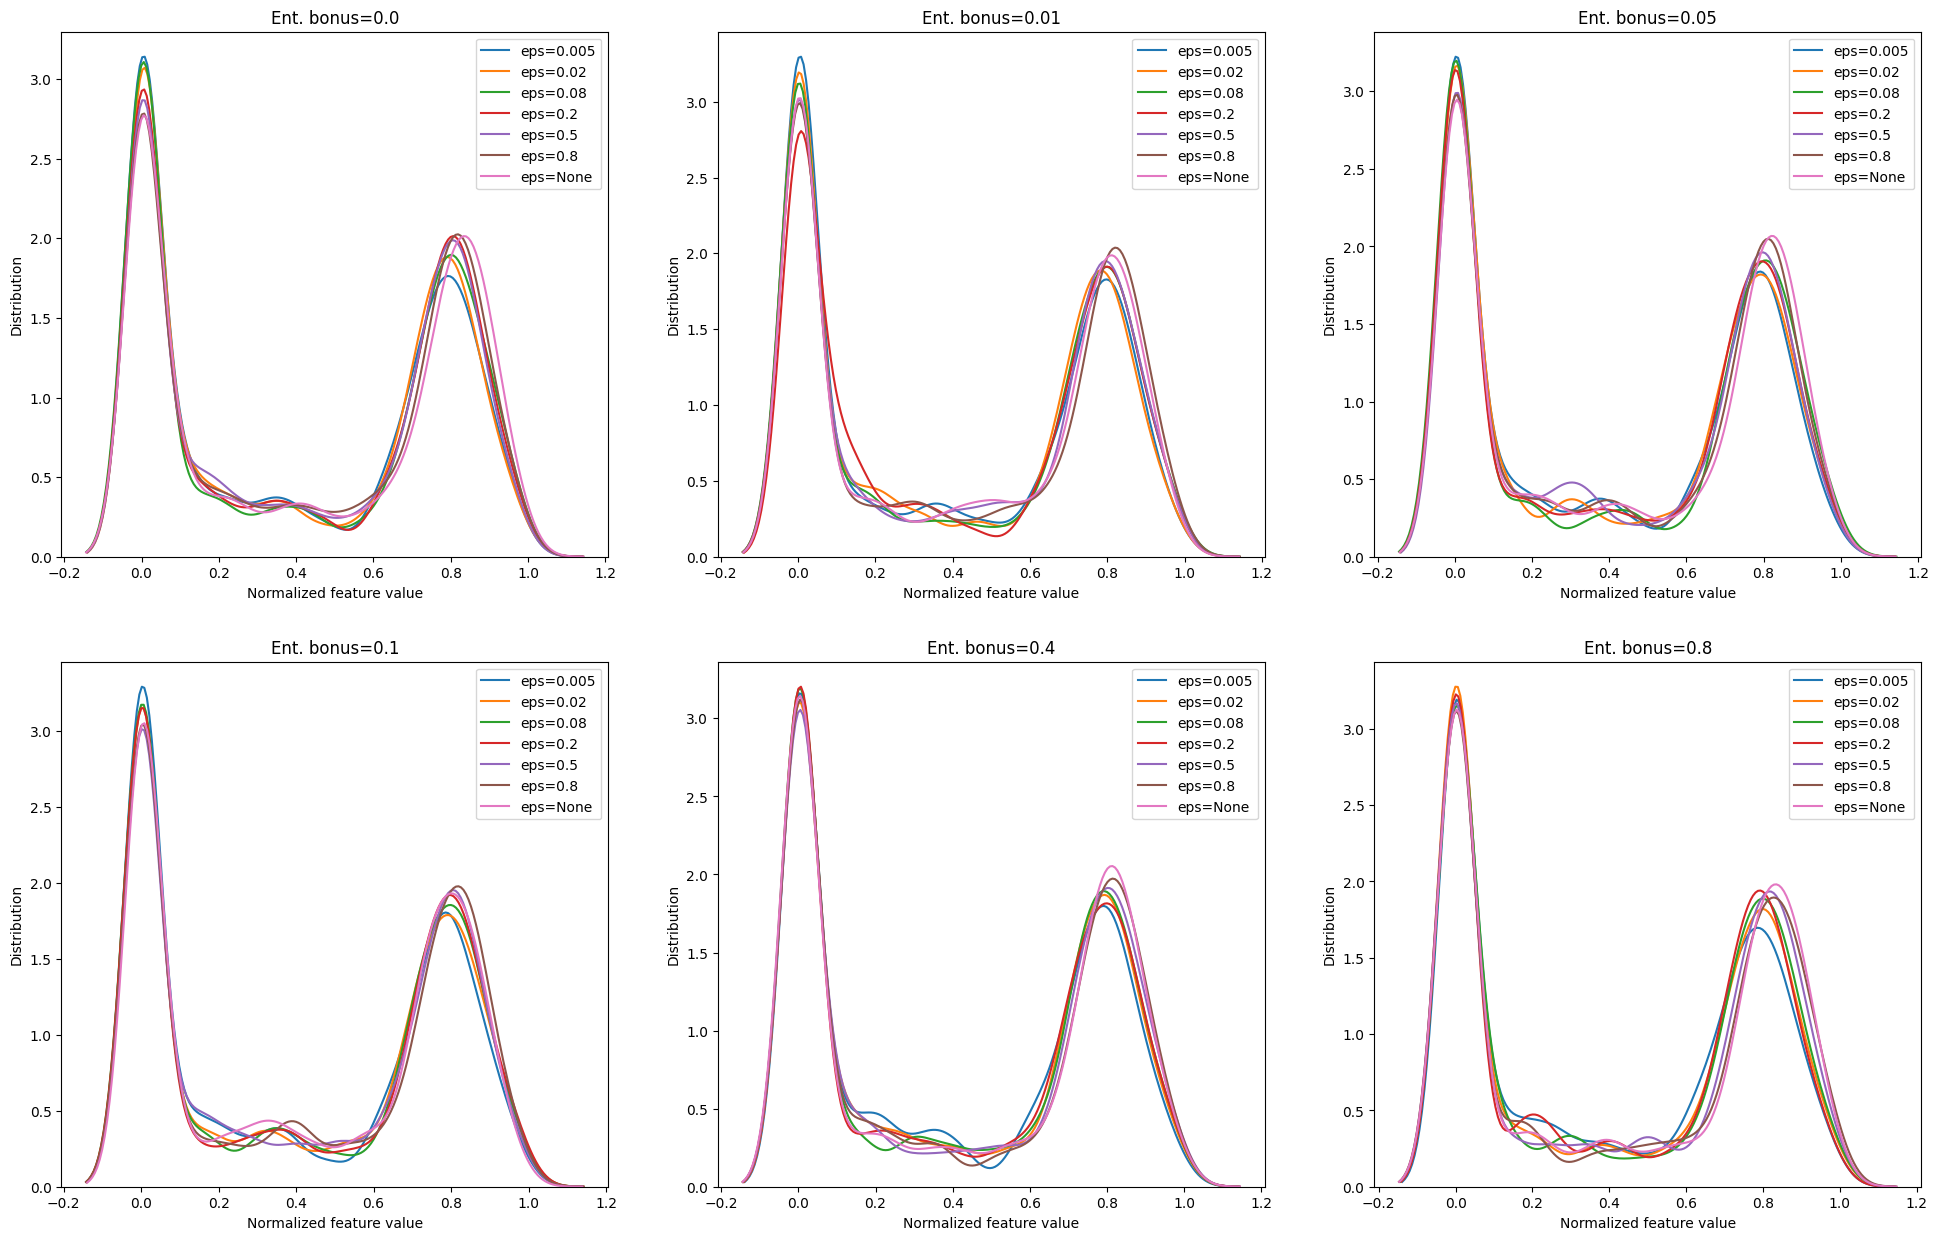

In [23]:
plot_sparsity("CartPole-v1", ents, clips)

## 5. Freeway

Actions shape: (8, 6, 7, 2500)
Features shape: (8, 6, 7, 2500, 256)
(2500, 2)


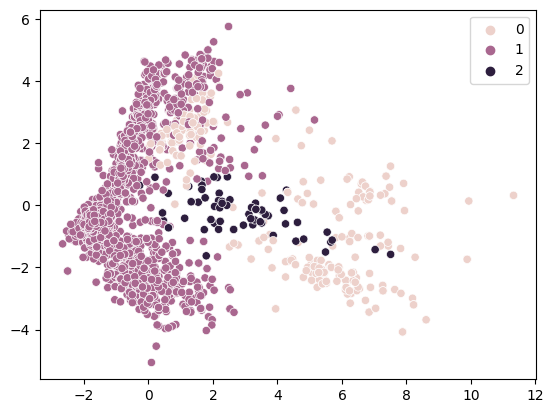

In [24]:
plot_features("Freeway-MinAtar", ents, clips)

Actions shape: (8, 6, 7, 2500)
Features shape: (8, 6, 7, 2500, 256)

Softmax accuracy


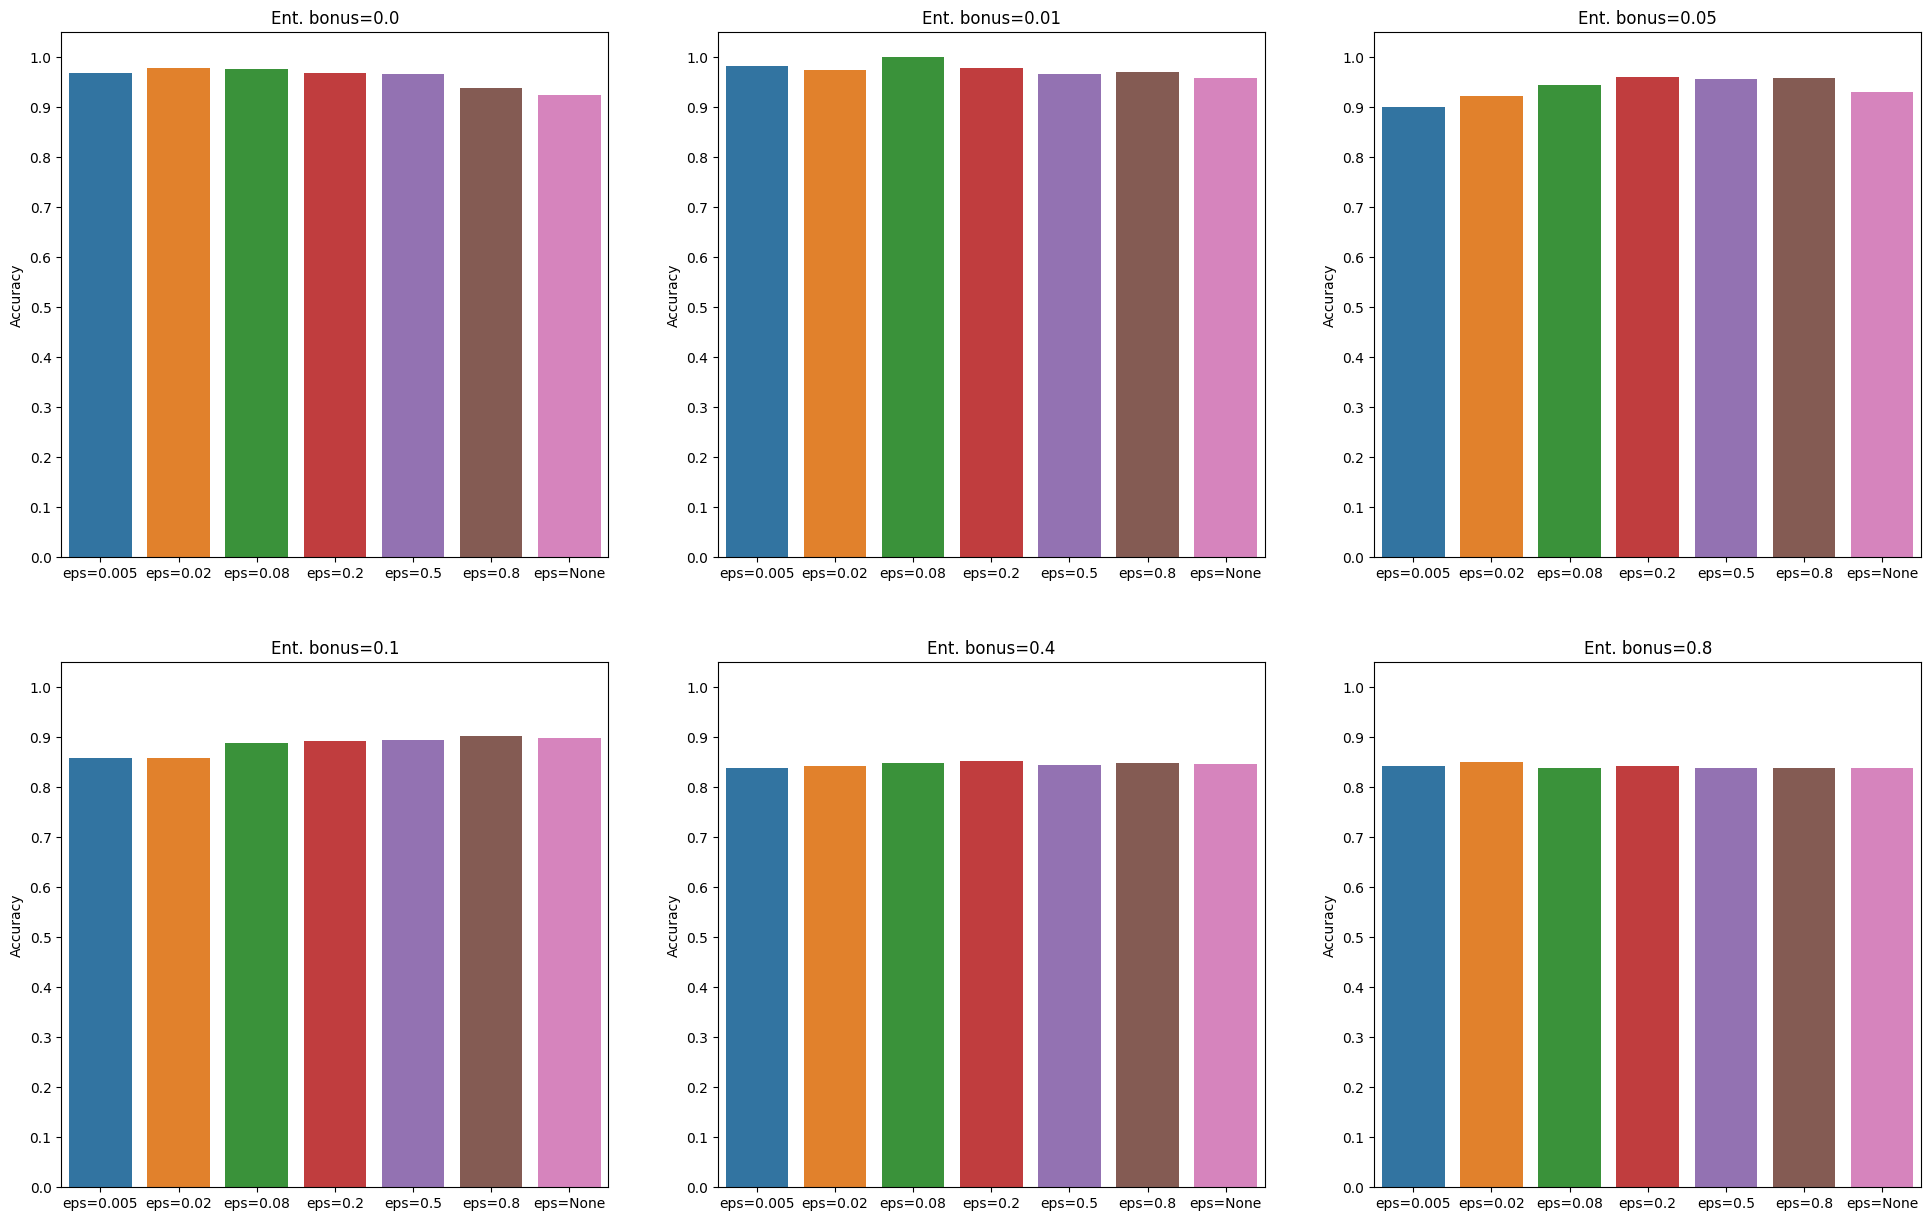

In [25]:
classify("Freeway-MinAtar", ents, clips, seed=0)

Actions shape: (8, 6, 7, 2500)
Features shape: (8, 6, 7, 2500, 256)

Softmax accuracy


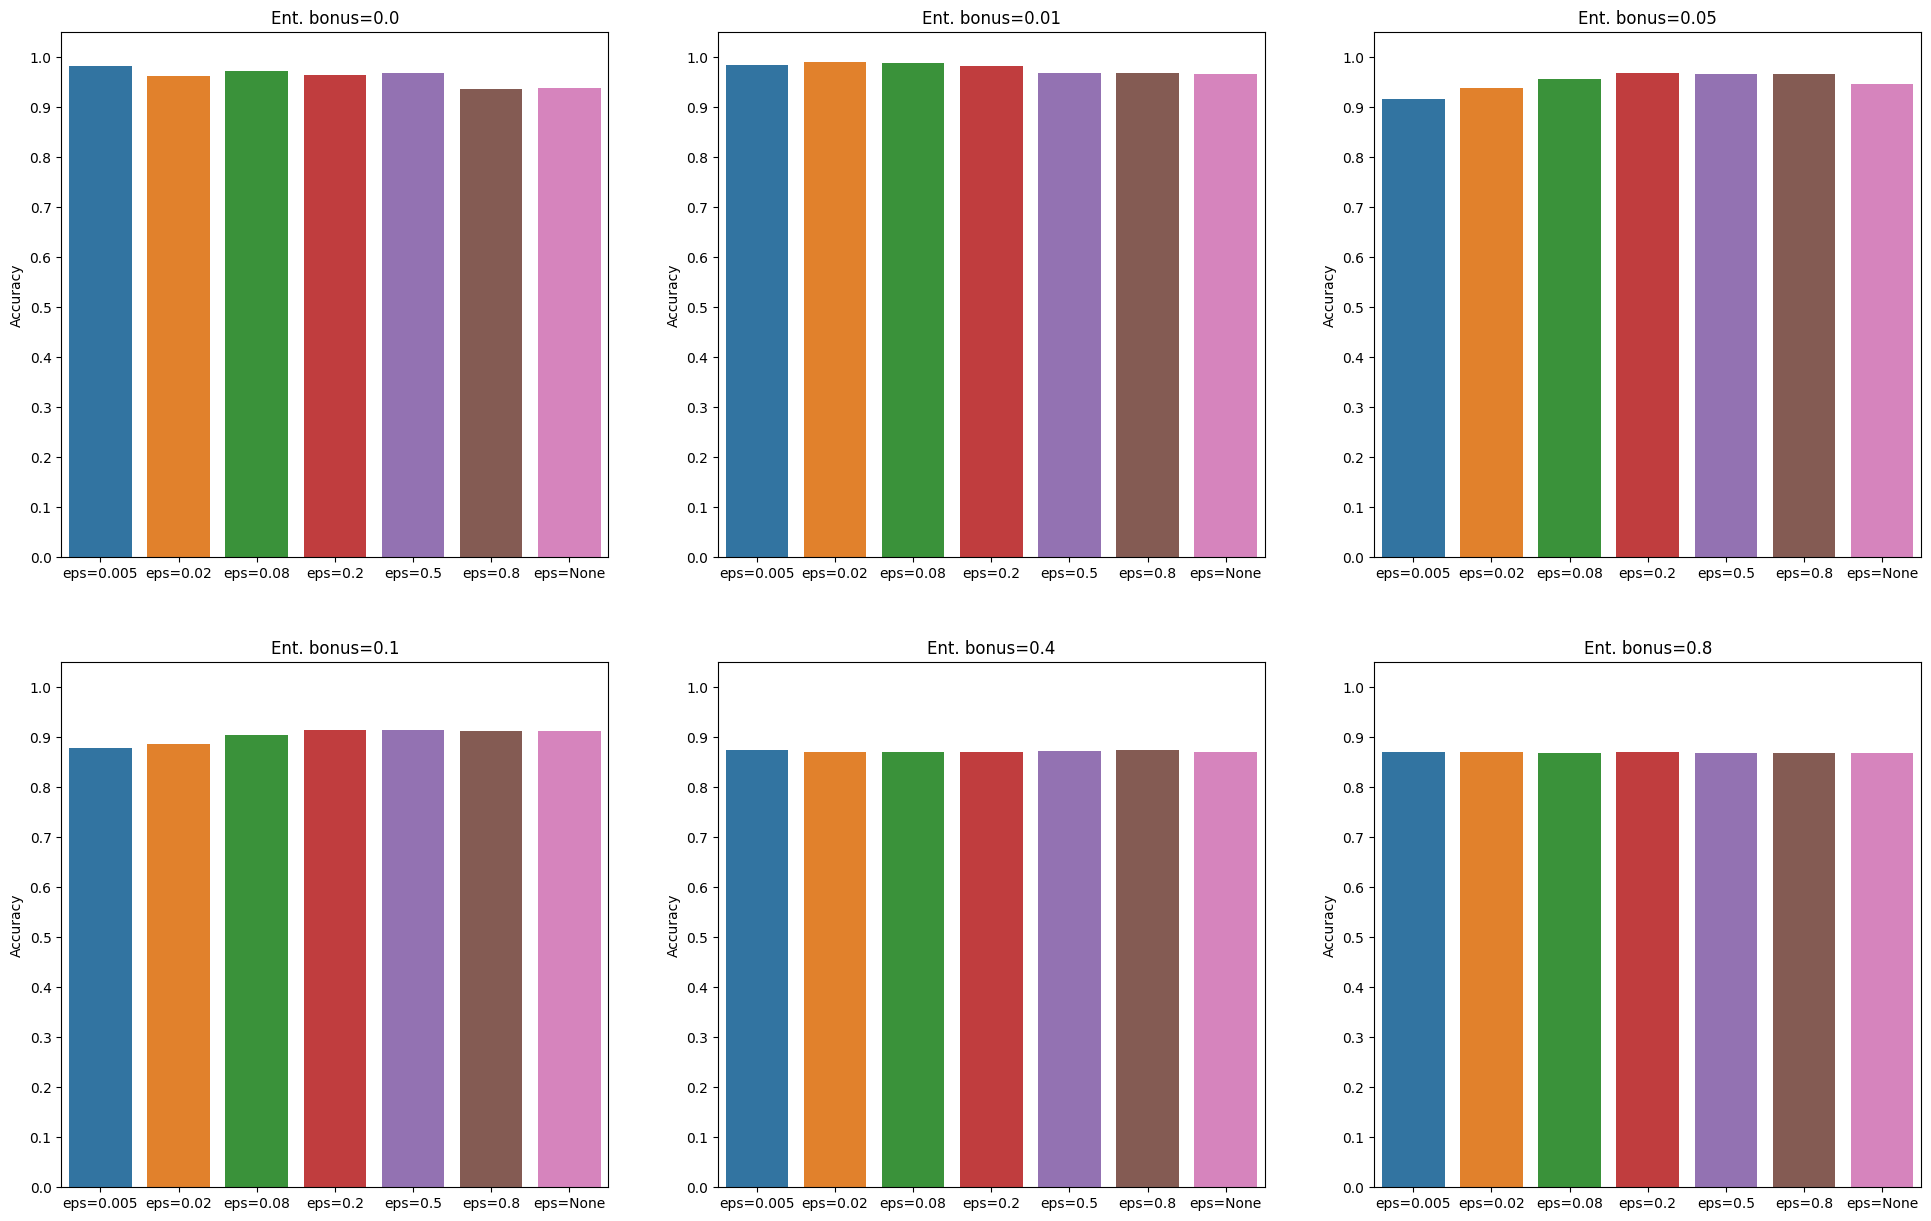

In [26]:
classify("Freeway-MinAtar", ents, clips, seed=3)

In [ ]:
plot_svd("Freeway-MinAtar", ents, clips)

Actions shape: (8, 6, 7, 2500)
Features shape: (8, 6, 7, 2500, 256)


Features shape: (8, 6, 7, 2500, 256)
Max feature: 17.93405

Abs values of feature matrix


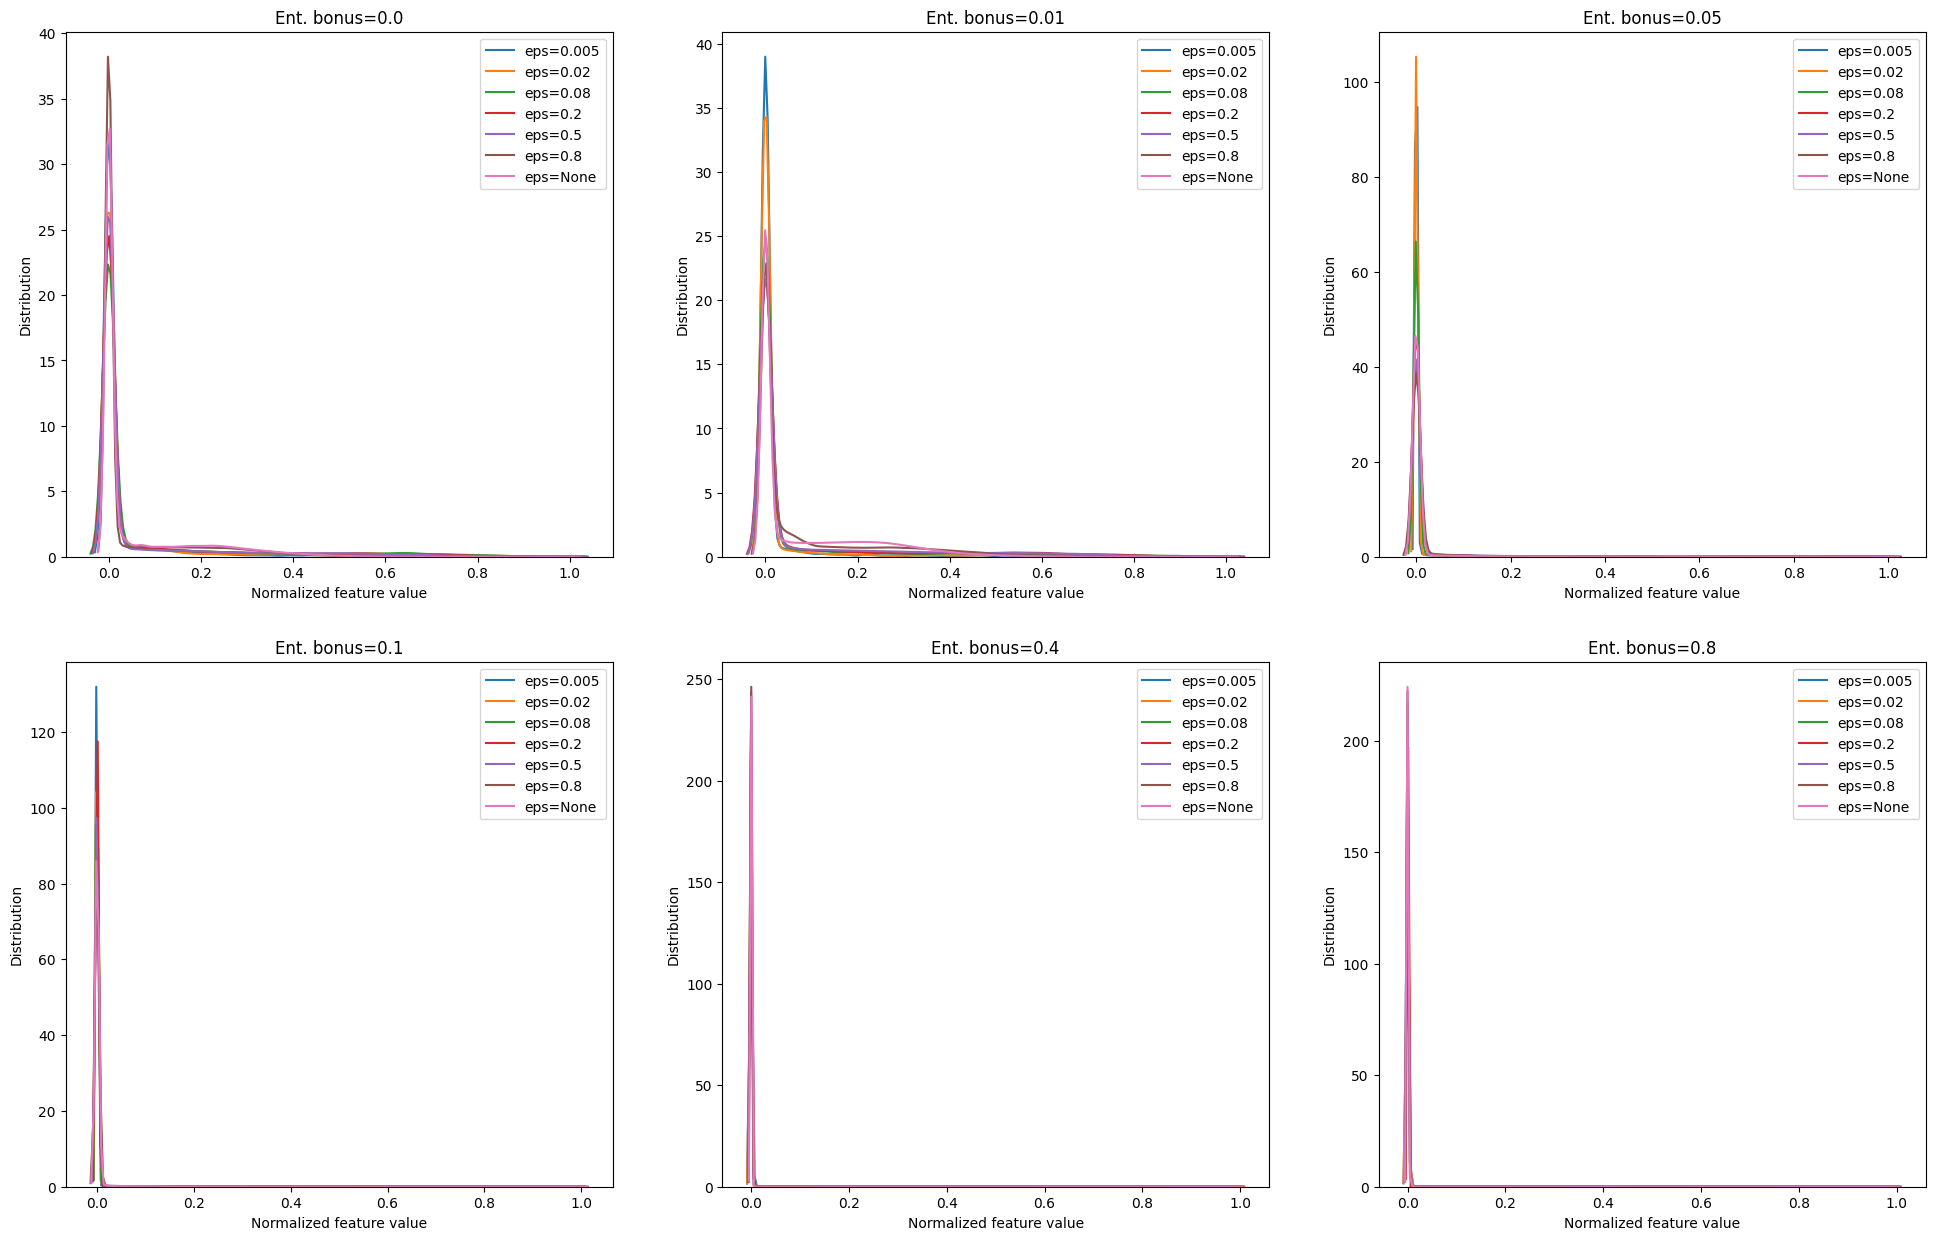

In [4]:
plot_sparsity("Freeway-MinAtar", ents, clips)

## 6. MountainCar

Actions shape: (8, 6, 7, 200)
Features shape: (8, 6, 7, 200, 64)
(200, 2)


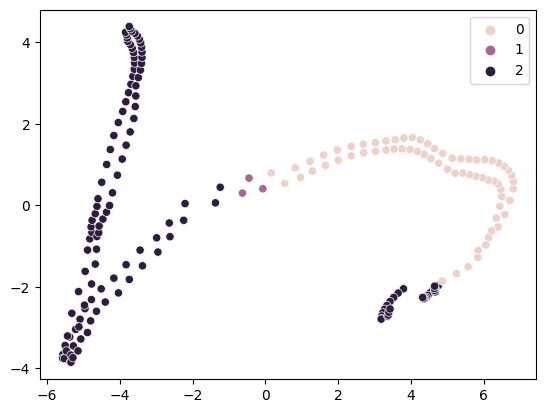

In [5]:
plot_features("MountainCar-v0", ents, clips)

Actions shape: (8, 6, 7, 200)
Features shape: (8, 6, 7, 200, 64)

Softmax accuracy


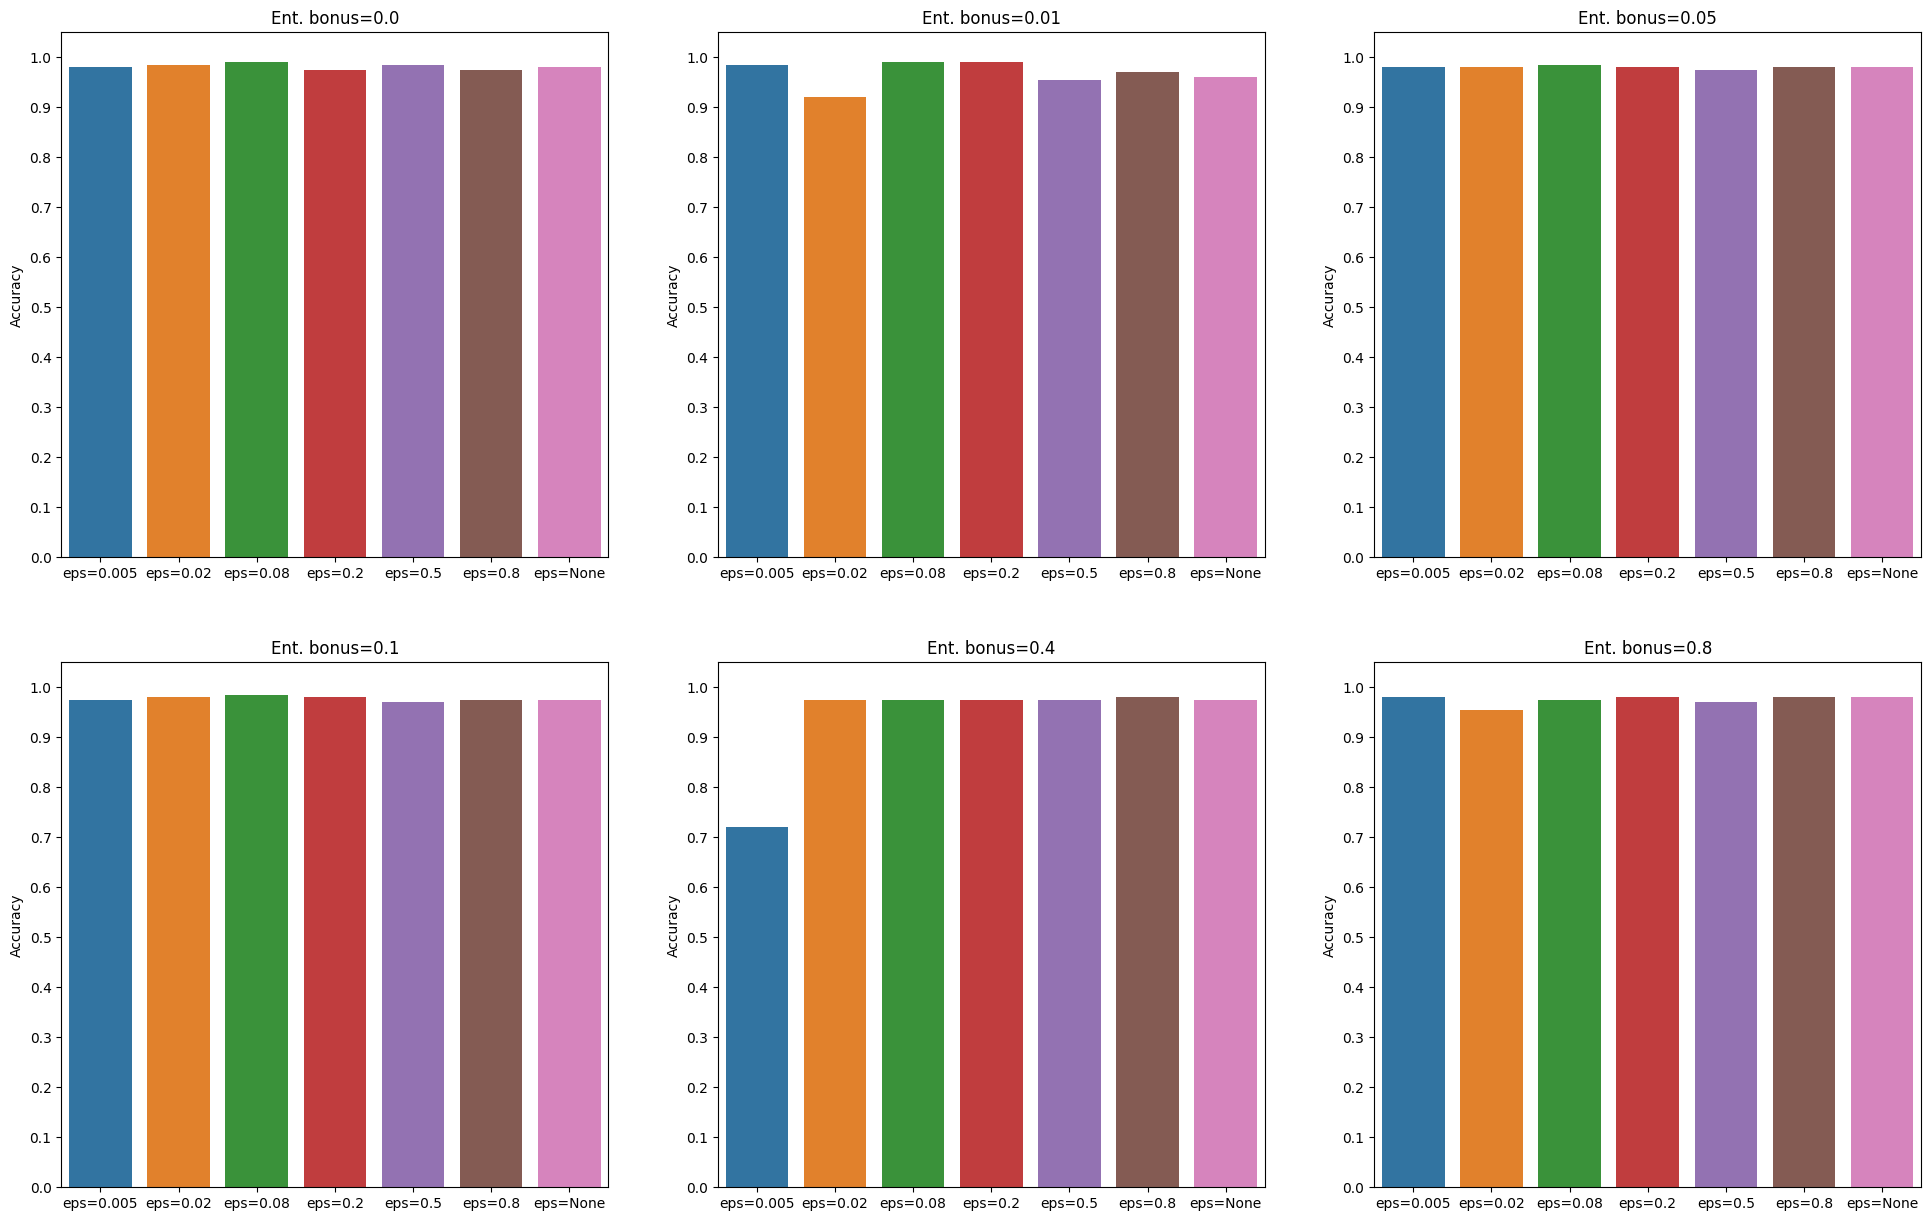

In [6]:
classify("MountainCar-v0", ents, clips, seed=0)

Actions shape: (8, 6, 7, 200)
Features shape: (8, 6, 7, 200, 64)

Softmax accuracy


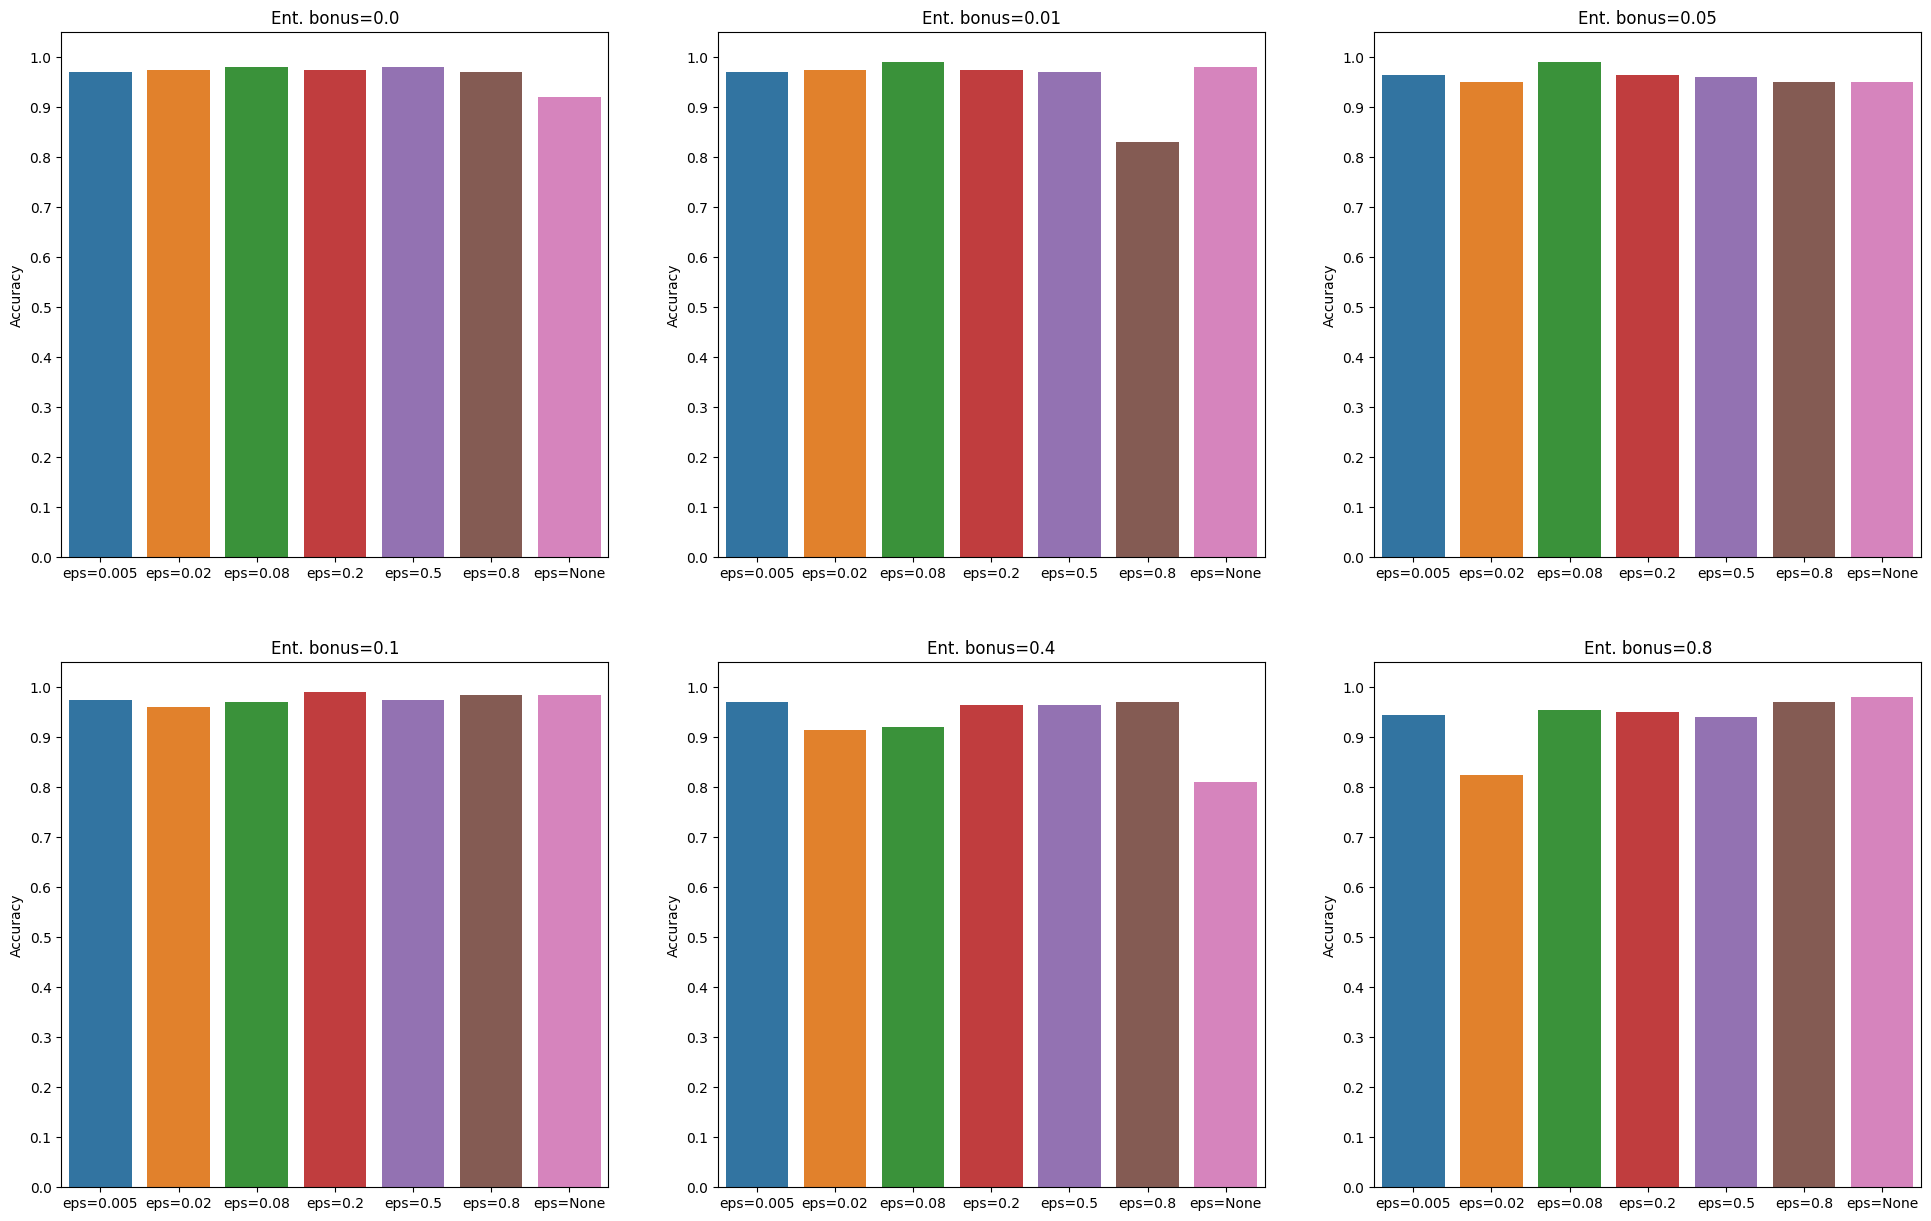

In [7]:
classify("MountainCar-v0", ents, clips, seed=3)

Actions shape: (8, 6, 7, 200)
Features shape: (8, 6, 7, 200, 64)
sF shape: (8, 6, 7, 64)
Max sF: 572.1922586674228

Singular values of feature matrix


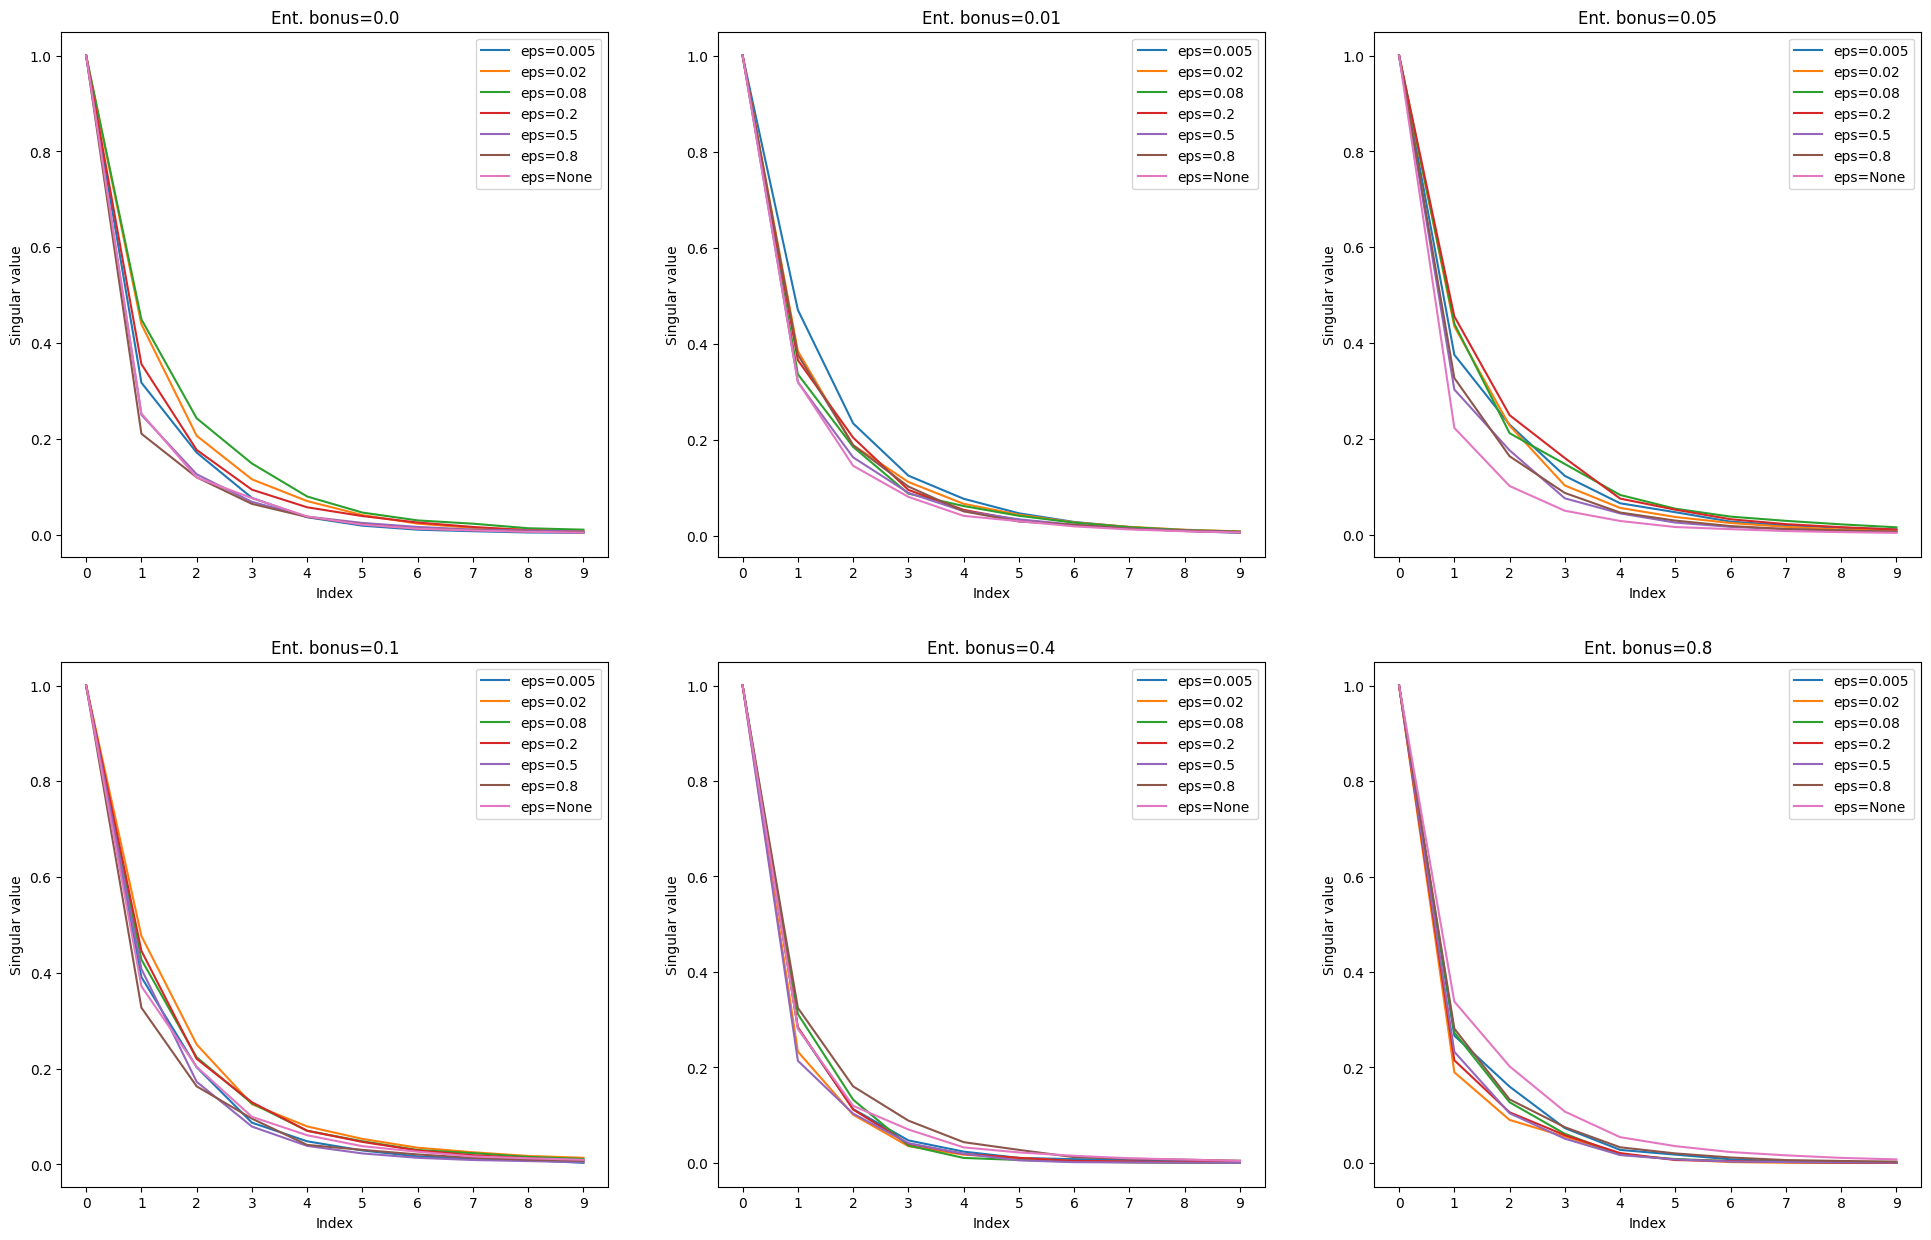

In [8]:
plot_svd("MountainCar-v0", ents, clips)

Features shape: (8, 6, 7, 200, 64)
Max feature: 34.83250183331857

Abs values of feature matrix


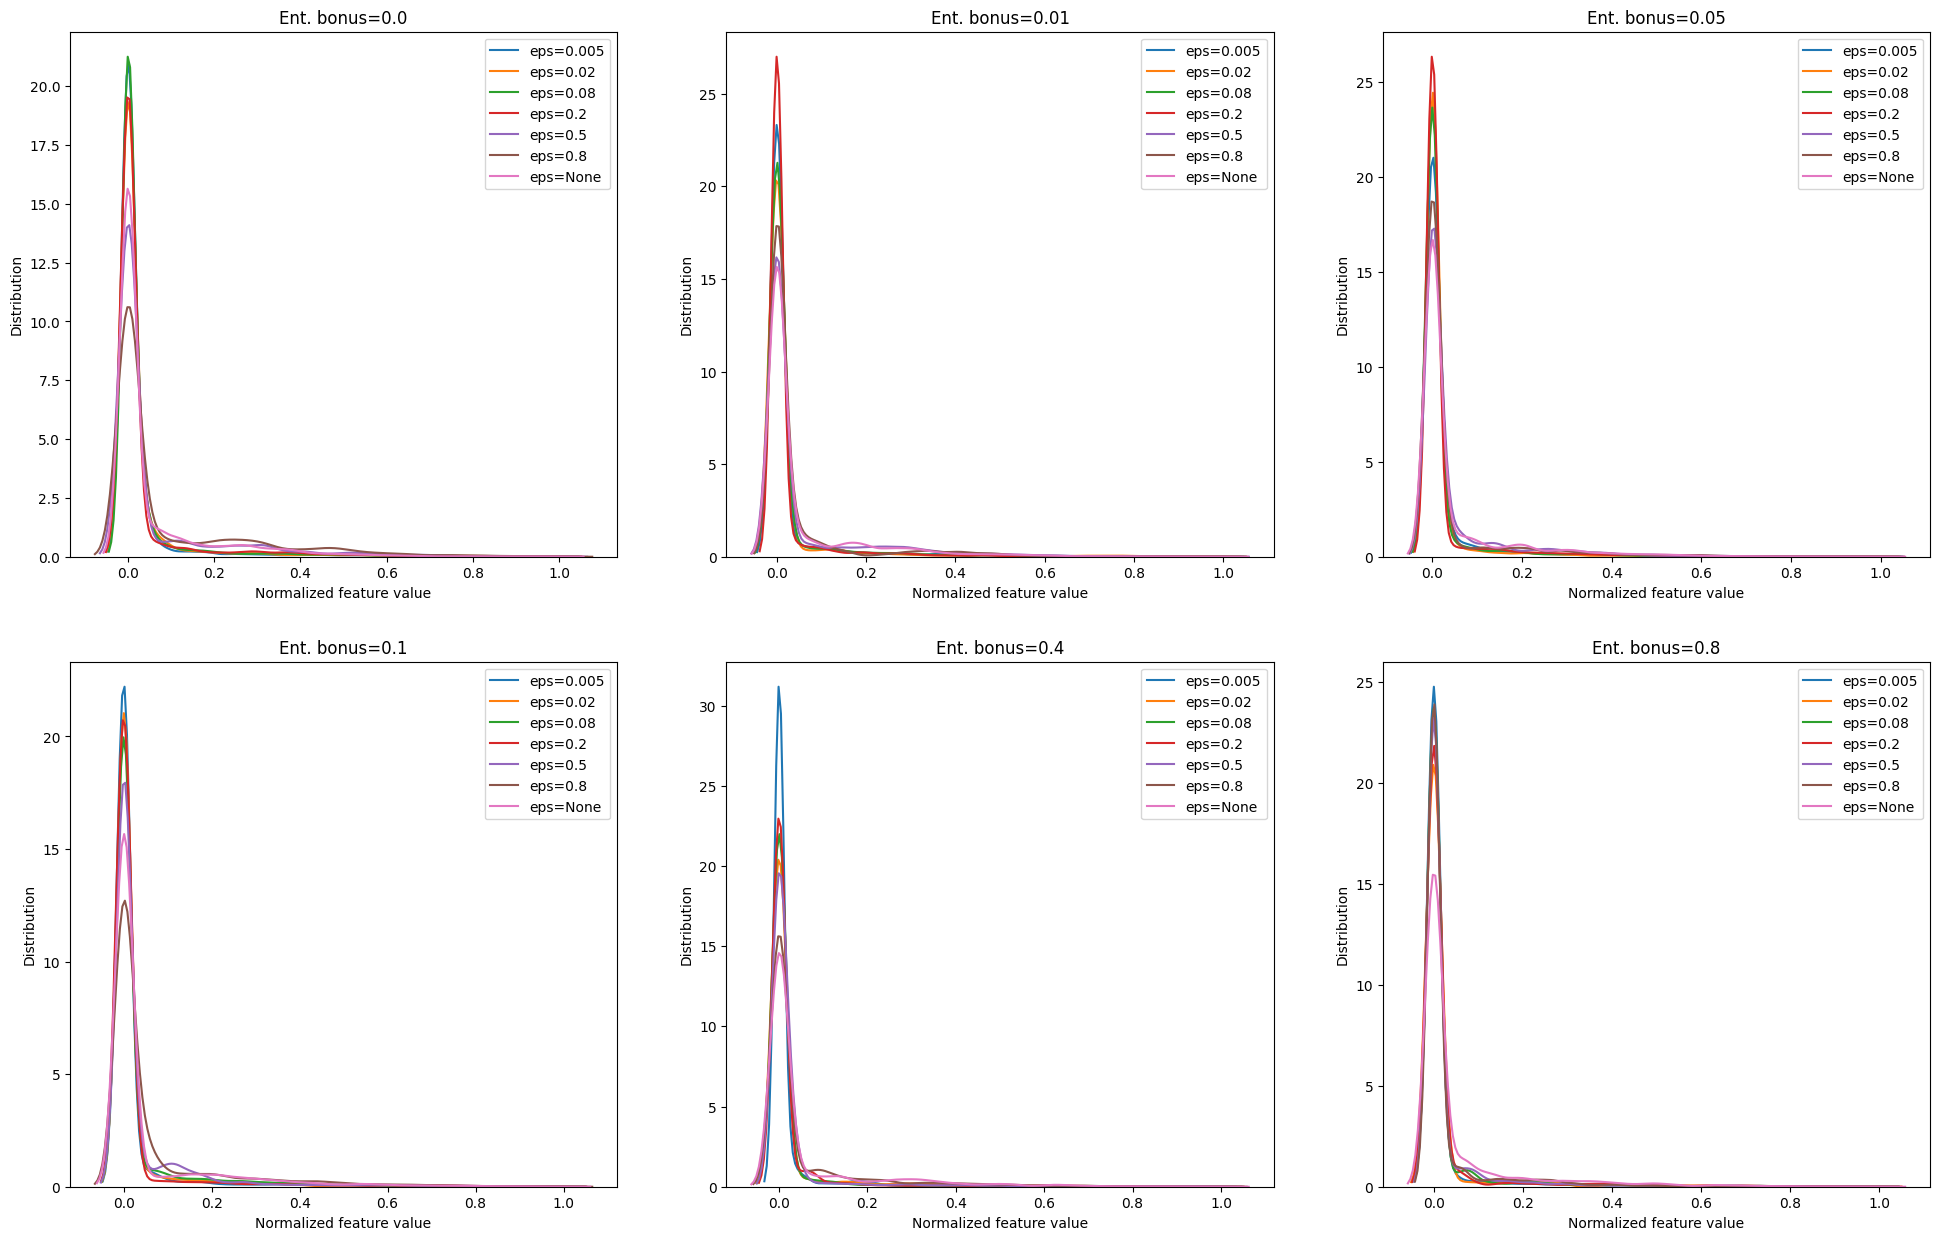

In [9]:
plot_sparsity("MountainCar-v0", ents, clips)

## 7. SpaceInvaders

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
(1000, 2)


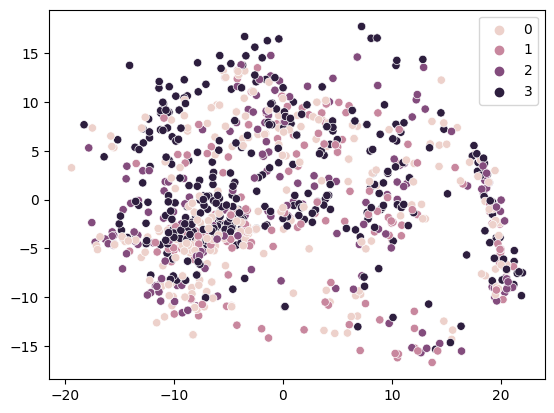

In [10]:
plot_features("SpaceInvaders-MinAtar", ents, clips)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)

Softmax accuracy


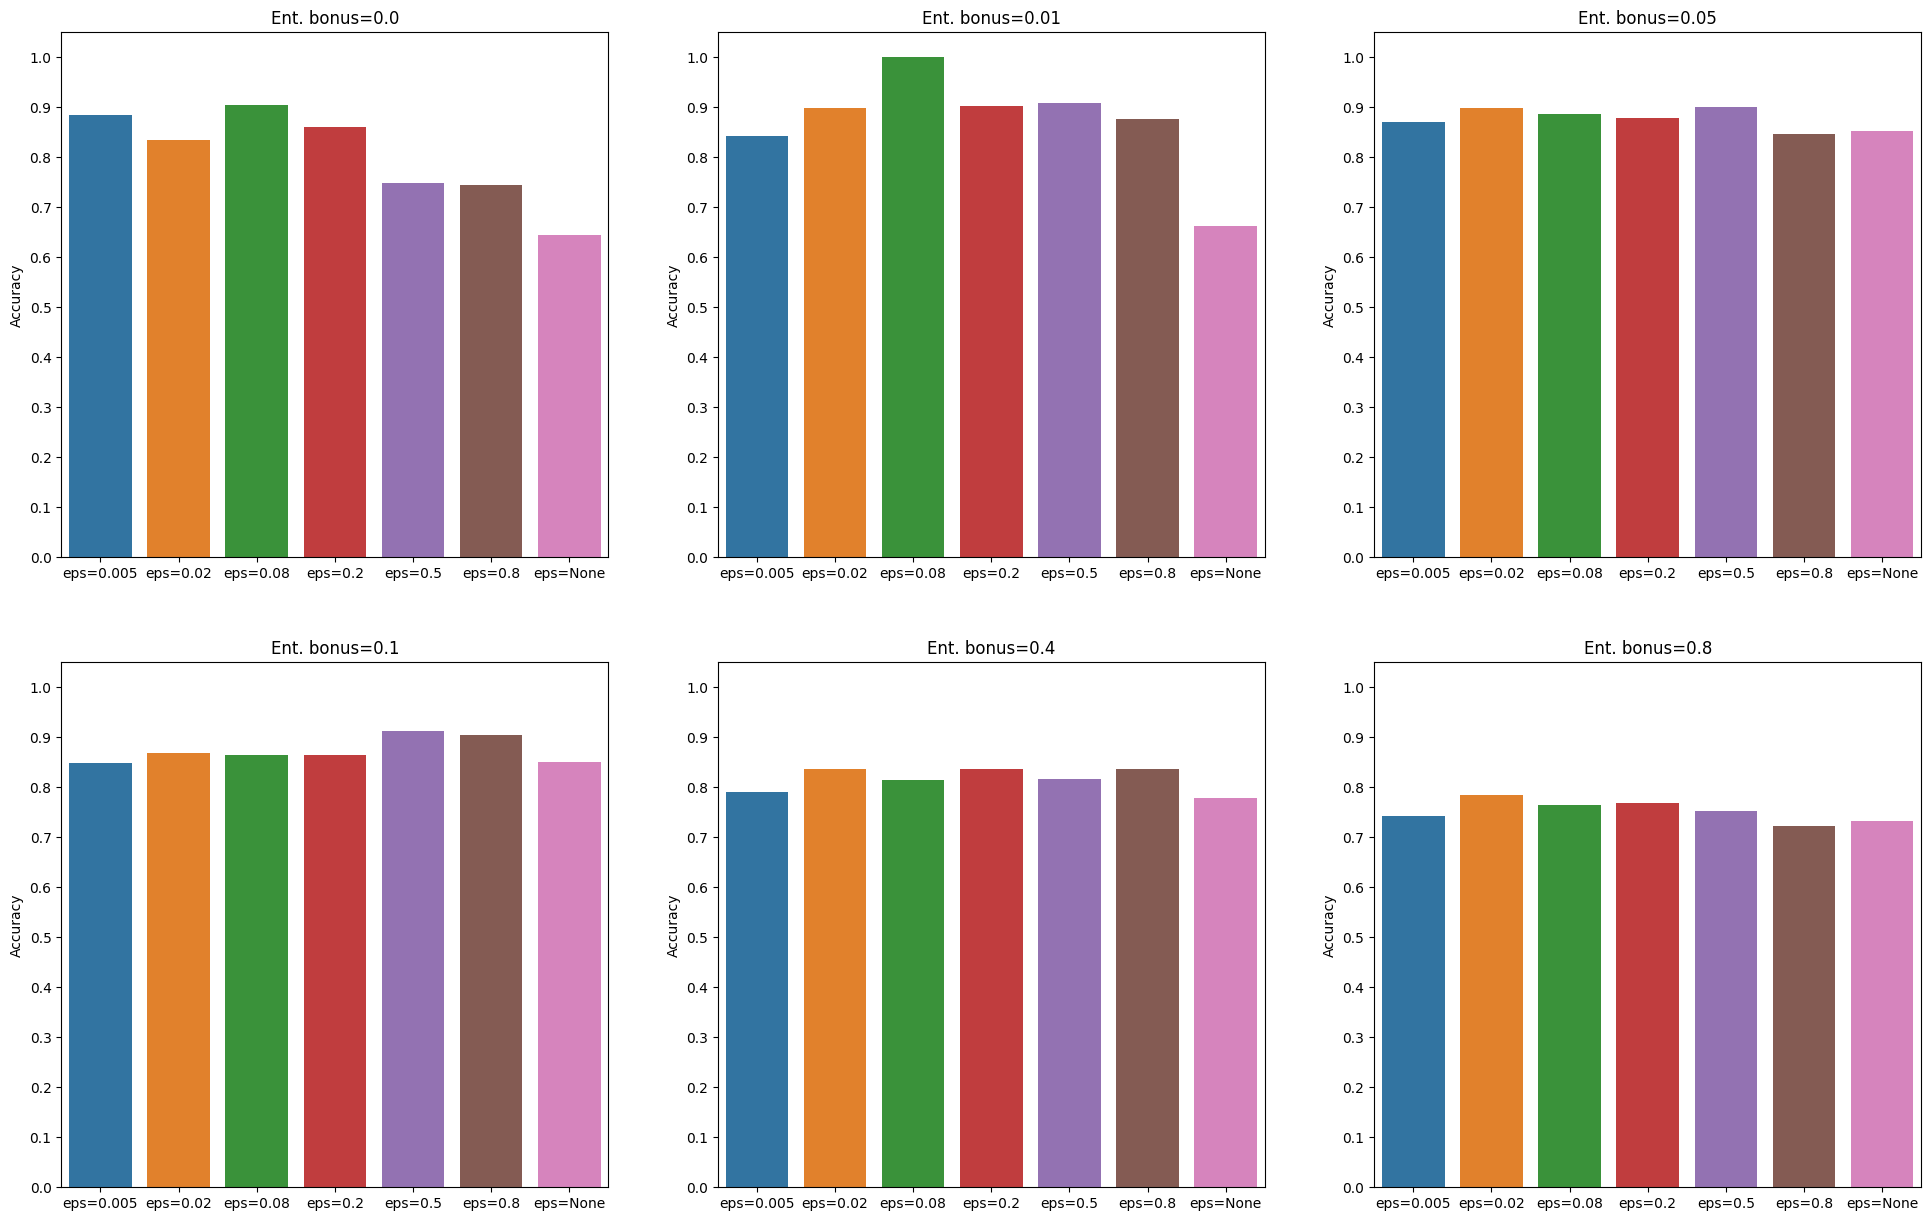

In [11]:
classify("SpaceInvaders-MinAtar", ents, clips, seed=0)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)

Softmax accuracy


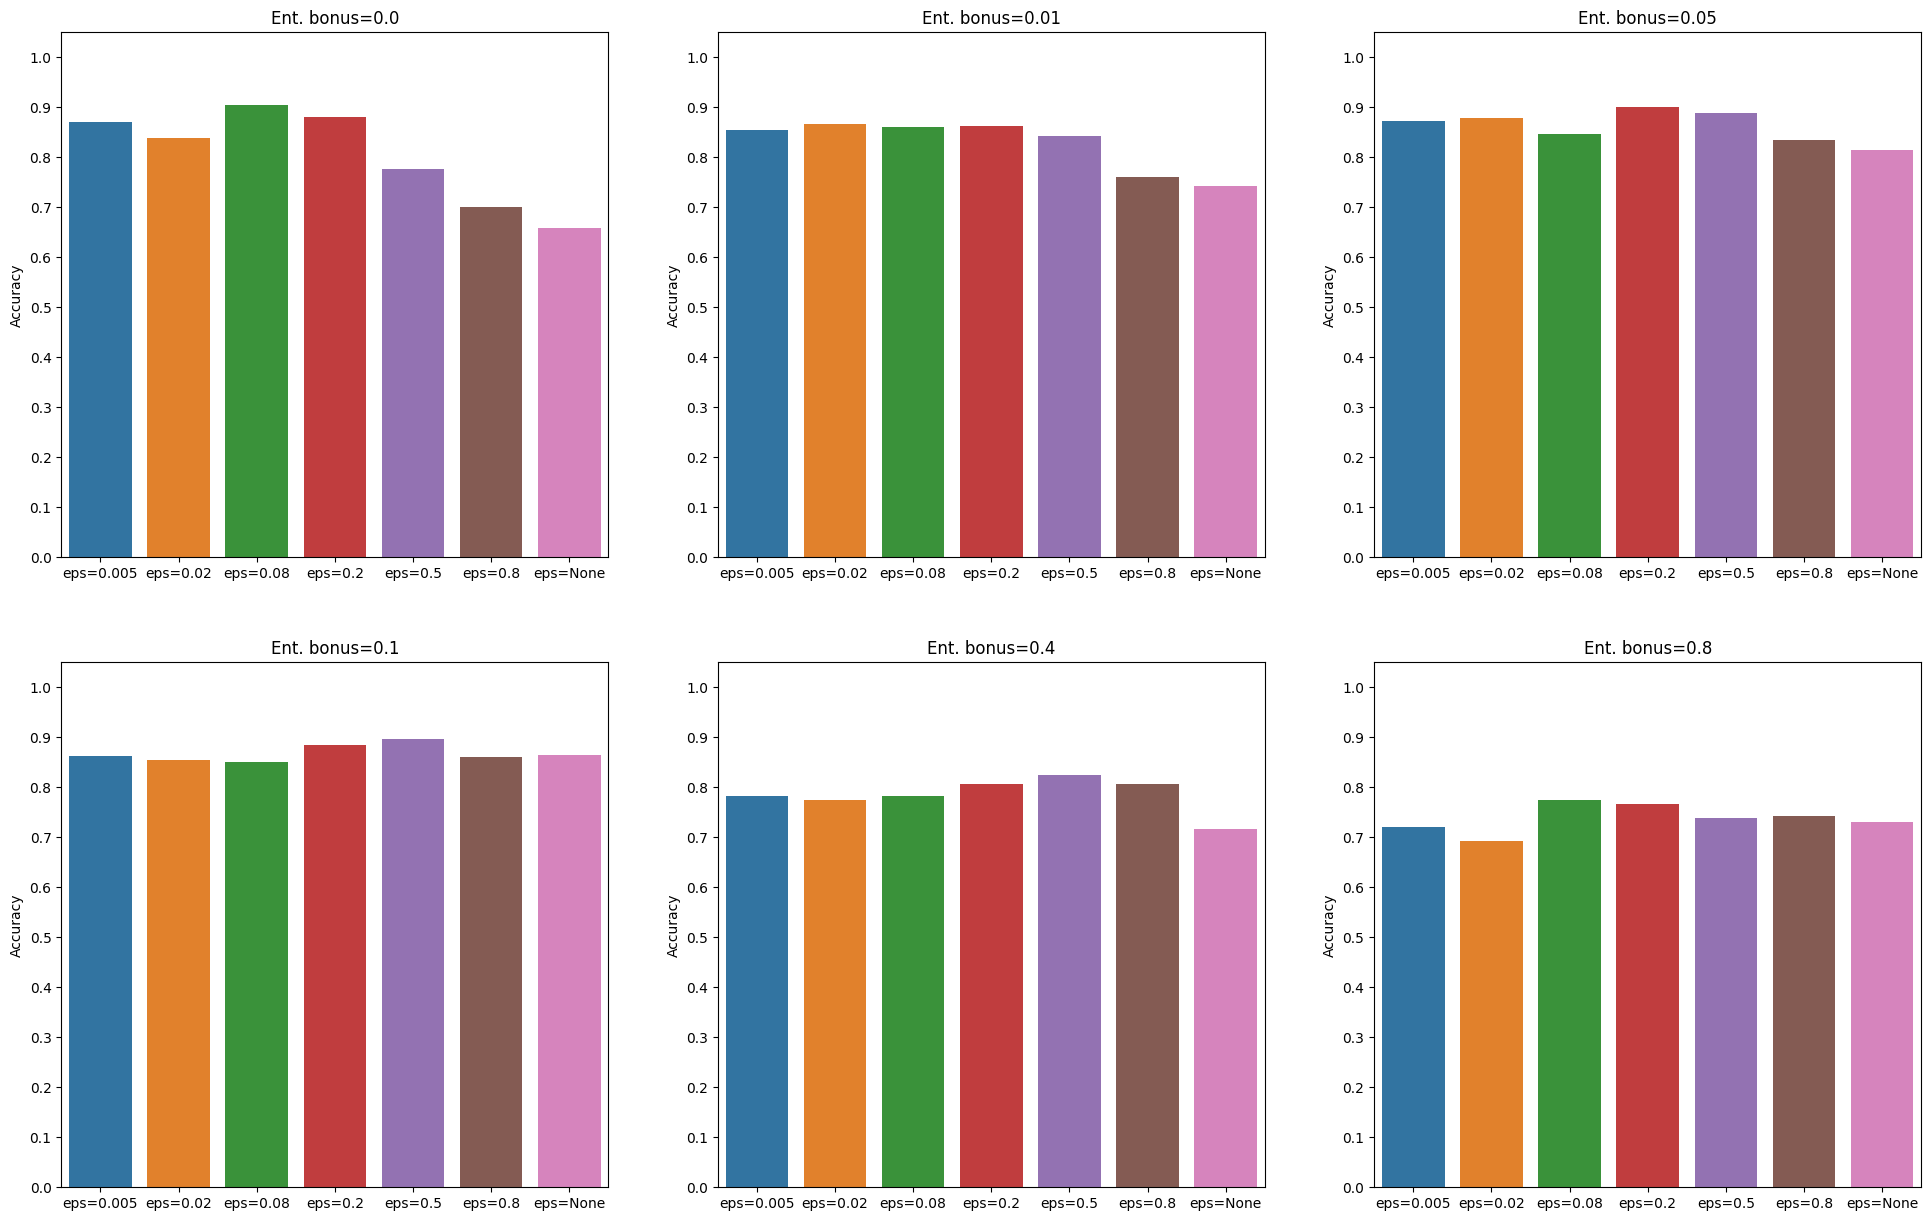

In [12]:
classify("SpaceInvaders-MinAtar", ents, clips, seed=3)

Actions shape: (8, 6, 7, 1000)
Features shape: (8, 6, 7, 1000, 256)
sF shape: (8, 6, 7, 256)
Max sF: 1783.4304

Singular values of feature matrix


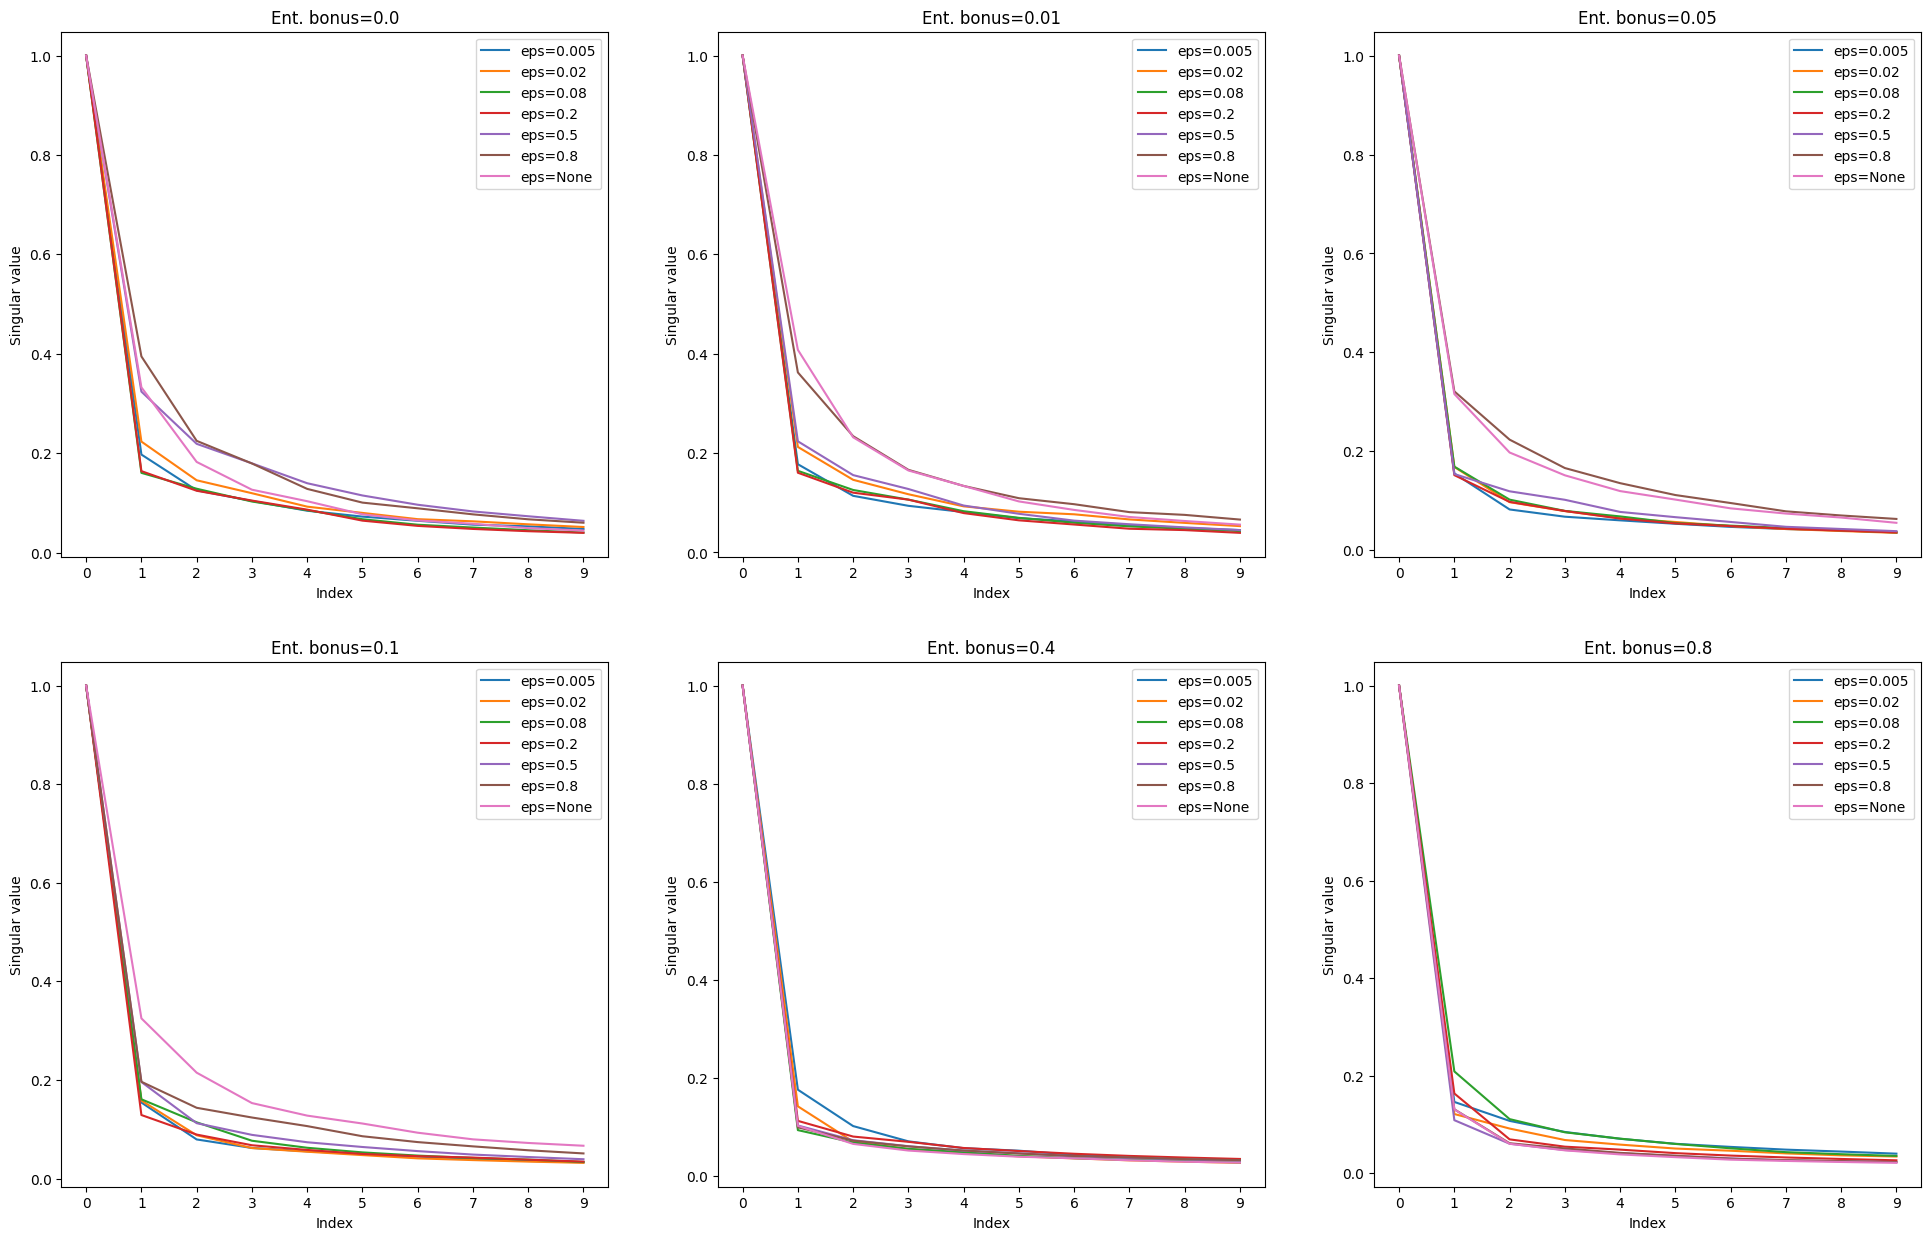

In [13]:
plot_svd("SpaceInvaders-MinAtar", ents, clips)

Features shape: (8, 6, 7, 1000, 256)
Max feature: 34.33486

Abs values of feature matrix


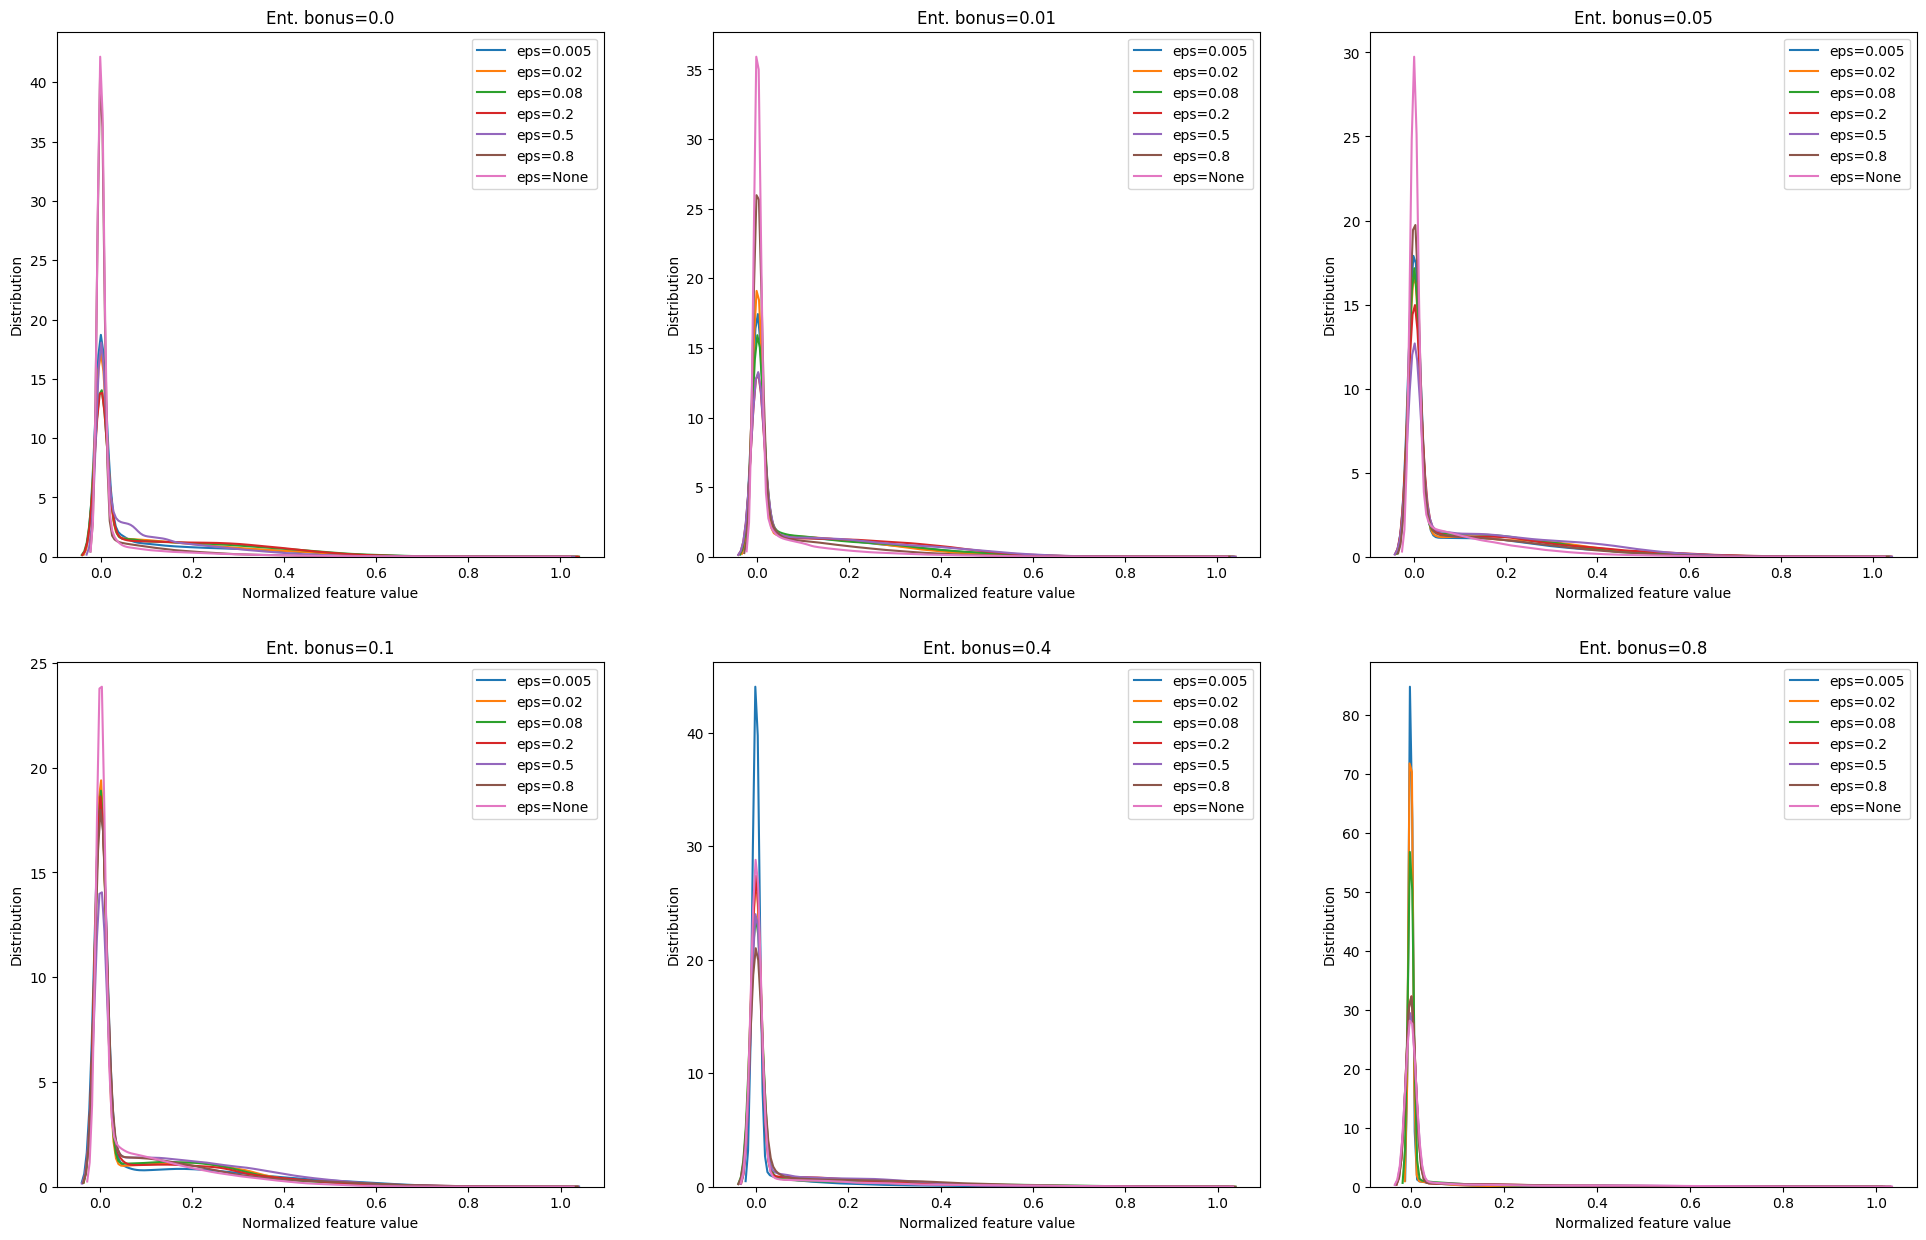

In [14]:
plot_sparsity("SpaceInvaders-MinAtar", ents, clips)